In [8]:
import geopandas as gpd
import rasterio
from rasterio import features
import numpy as np
from pyproj import Transformer
from scipy.interpolate import RegularGridInterpolator
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm

### Extract Ice Shelf boundaries as raster and assign corresponding index

In [89]:
ICESHELVES = gpd.read_file("/Users/dinh/Desktop/PhD/ICESHELVES_NAME/qgisMaps/IceBound2008_[v2.2]/IceBoundaries_Y2008_Antarctica_v2.2.shp")

In [90]:
Rignot_ISNames = ["LarsenG",
       "LarsenF",
       "LarsenE",
       "LarsenD", 
       "LarsenC",
       "LarsenB",
       "Wordie",
       "Wilkins",
       "Bach",
       "George_VI",
       "Stange", ### Ant Peninsula 
       "Ronne",
       "Ferrigno",
       "Venable",
       "Abbot",
       "Cosgrove",
       "Pine_Island",
       "Thwaites",
       "Crosson",
       "Dotson",
       "Getz",
       "Land",
       "Nickerson",
       "Sulzberger",
       "Swinburne",
       "Withrow",
       "Ross_West",### West Ant
       "Ross_East",
       "Drygalski",
       "Nansen",
       "Aviator",
       "Mariner",
       "Lillie",
       "Rennick",
       "Cook",
       "Ninnis",
       "Mertz",
       "Dibble",
       "Holmes",
       "Moscow_University",
       "Totten",
       "Vincennes_Bay",
       "Conger_Glenzer",
       "Tracy_Tremenchus",
       "Shackleton",
       "West",
       "Publications",
       "Amery",
       "WilmaRobertDowner",
       "Edward_VIII",
       "Rayner_Thyer",
       "Shirase",
       "Prince_Harald",
       "Baudouin",
       "Borchgrevink",
       "Lazarev",
       "Nivl",
       "Vigrid",
       "Fimbul",
       "Jelbart",
       "Atka",
       "Ekstrom",
       "Quar",
       "Riiser-Larsen",
       "Brunt_Stancomb",
       "Filchner"]

In [114]:
for index in range (len(ICESHELVES)): ## Iterate through each Ice shelf in Shapefile
    
    ISname = ICESHELVES.at[index,'NAME'] ## Extract Ice Shelf's name 
 
    if ISname is None or ISname == 'Islands': ## Skip "Islands", mark with nan
        ICESHELVES['Rignot_Index'][index] = np.nan
        continue
        
    if ISname in Rignot_ISNames: ## If name is in list from Rignot et al, mark row with corresponding index from list
        ICESHELVES['Rignot_Index'][index] = Rignot_ISNames.index(ISname)

    else: ## Otherwise, mark with nan
        ICESHELVES['Rignot_Index'][index] = np.nan

In [115]:
## Open and obtain reference csr 
rst = rasterio.open("/Users/dinh/Desktop/Manuscript4/SOhi_v2_Basal_Melt_Rates.tiff")
meta = rst.meta.copy()
meta.update(compress='lzw')

In [116]:
with rasterio.open('ISmask_v1.tiff', 'w+', **meta) as out: ## Write new file
    out_arr = out.read(1)

    shapes = ((geom,value) for geom, value in zip(ICESHELVES.geometry, ICESHELVES.Rignot_Index)) ## zip list index

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform) ## Rasterize polygons and populate with list index
    out.write_band(1, burned) ## Write out data 

/Users/dinh/miniforge3/envs/ch4/lib/python3.13/site-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 1419 will not be rasterized.
  warnings.warn(
/Users/dinh/miniforge3/envs/ch4/lib/python3.13/site-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 1420 will not be rasterized.
  warnings.warn(
/Users/dinh/miniforge3/envs/ch4/lib/python3.13/site-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 1421 will not be rasterized.
  warnings.warn(
/Users/dinh/miniforge3/envs/ch4/lib/python3.13/site-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 1422 will not be rasterized.
  warnings.warn(
/Users/dinh/miniforge3/envs/ch4/lib/python3.13/site-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 1423 will not be rasterized.
  warnings.warn(
/Users/dinh/miniforge3/envs/ch4/lib/python3.13/site-packages

### Convert to SOhi grid

In [2]:
with rasterio.open('ISmask_v1.tiff') as dataset:
    data = dataset.read()
    data = data[0,:,:]

In [18]:
## XY coords 
X = np.arange(-3150000 + 225,  3150000,  450)
Y = np.arange( 3150000 - 225, -3150001, -450)
# Y = np.arange(-3150000 + 225,  3150000,  450)


## SOhi lat lon
GRID = h5py.File('/Volumes/Project/SOhi_Data/GRID_v8.mat')
XC = np.asarray(GRID['XC'][0,:])
XC = ((XC + 180) %360) - 180

YC = np.asarray(GRID['YC'][:, 0])

ICESHELVES = np.load('Meta_Data/Ice_Draft.npy')
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031")

In [40]:
Mask = np.zeros(ICESHELVES.shape)
Mask[:] = np.nan

for i in tqdm(range(len(YC))):
    for j in range(len(XC)):
        if ICESHELVES[i,j] ==0:
            continue 

        res = transformer.transform(YC[i], XC[j])
        
        ix = np.argmin(abs(X - res[0]))
        iy = np.argmin(abs(Y - res[1]))

        val = data[iy, ix]

        if np.isnan(val):
            Mask[i,j] = 99
        else:
            Mask[i,j] = val

100%|█████████████████████████████████████████████████████████████████| 3456/3456 [01:15<00:00, 45.83it/s]


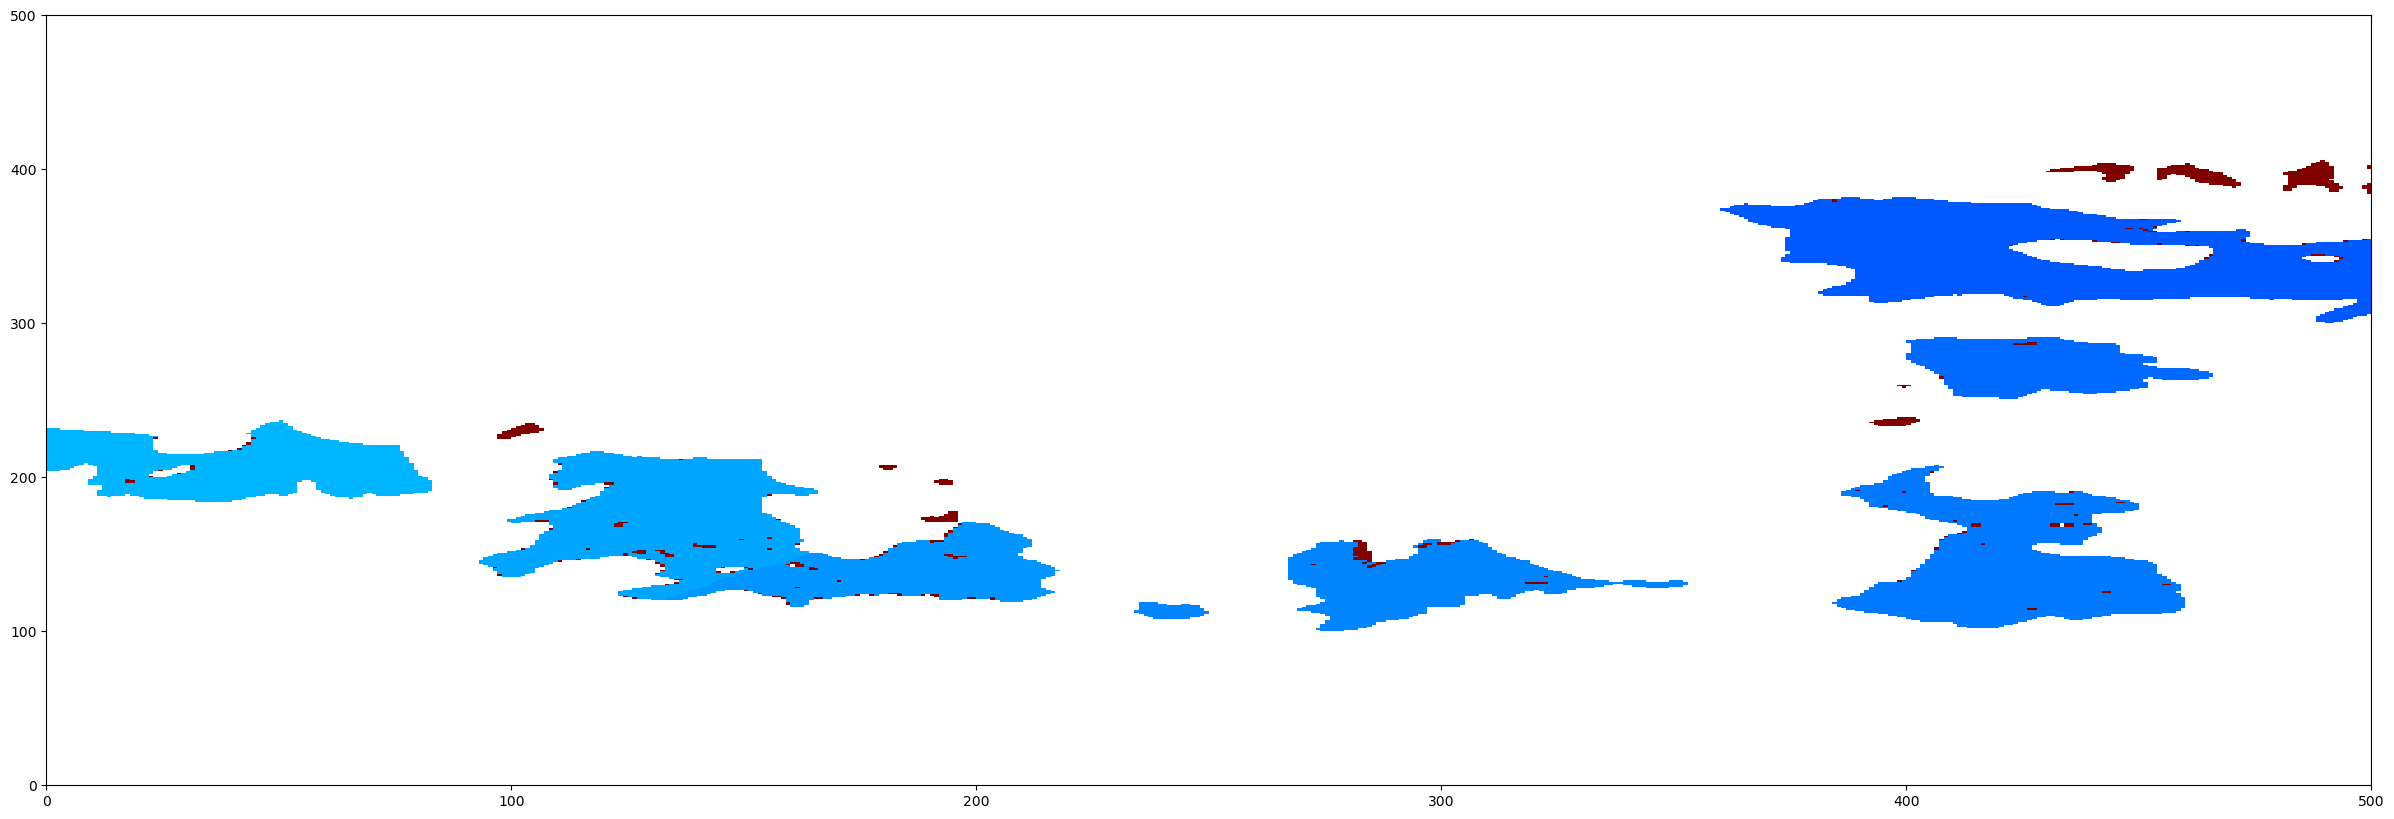

In [44]:
fig, ax = plt.subplots(figsize=(30,10))

ax.pcolormesh(Mask[1000:1500, 5800: 6300], vmin=0, vmax=66, cmap='jet') 

In [45]:
np.save("ISmask_v2.npy", Mask)

### Clean mask

In [2]:
data = np.load("ISmask_v2.npy")
ICESHELVES = np.load('Meta_Data/Ice_Draft.npy')
ICESHELVES[ICESHELVES != 0] = 1

data[ICESHELVES==0] = np.nan
data[data > 99] = 99

In [3]:
for i in tqdm(range(data.shape[0])):
    for j in range(data.shape[1]):
        if ICESHELVES[i,j] == 1:
            N = i + 1
            S = i - 1
            E = j + 1
            W = j - 1

            vlist = []
            
            if ~np.isnan(data[N, j]):
                vlist.append(data[N, j]) 

            if ~np.isnan(data[S, j]):
                vlist.append(data[S, j]) 

            if ~np.isnan(data[i, W]):
                vlist.append(data[i, W]) 

            if ~np.isnan(data[N, W]):
                vlist.append(data[N, W]) 

            if ~np.isnan(data[S, W]):
                vlist.append(data[S, W]) 

            if E < 8640:

                if ~np.isnan(data[N, E]):
                    vlist.append(data[N, E]) 
    
                if ~np.isnan(data[i, E]):
                    vlist.append(data[i, E]) 
    
                if ~np.isnan(data[S, E]):
                    vlist.append(data[S, E]) 

            vlist = [i for i in vlist if i < 66]
            vlist = list(set(vlist))
            
            if len(vlist) == 1:
                data[i,j] = vlist[0]

100%|████████████████████████████████████████████████████████████████| 3456/3456 [00:16<00:00, 214.08it/s]


In [5]:
data[data>66] = np.nan

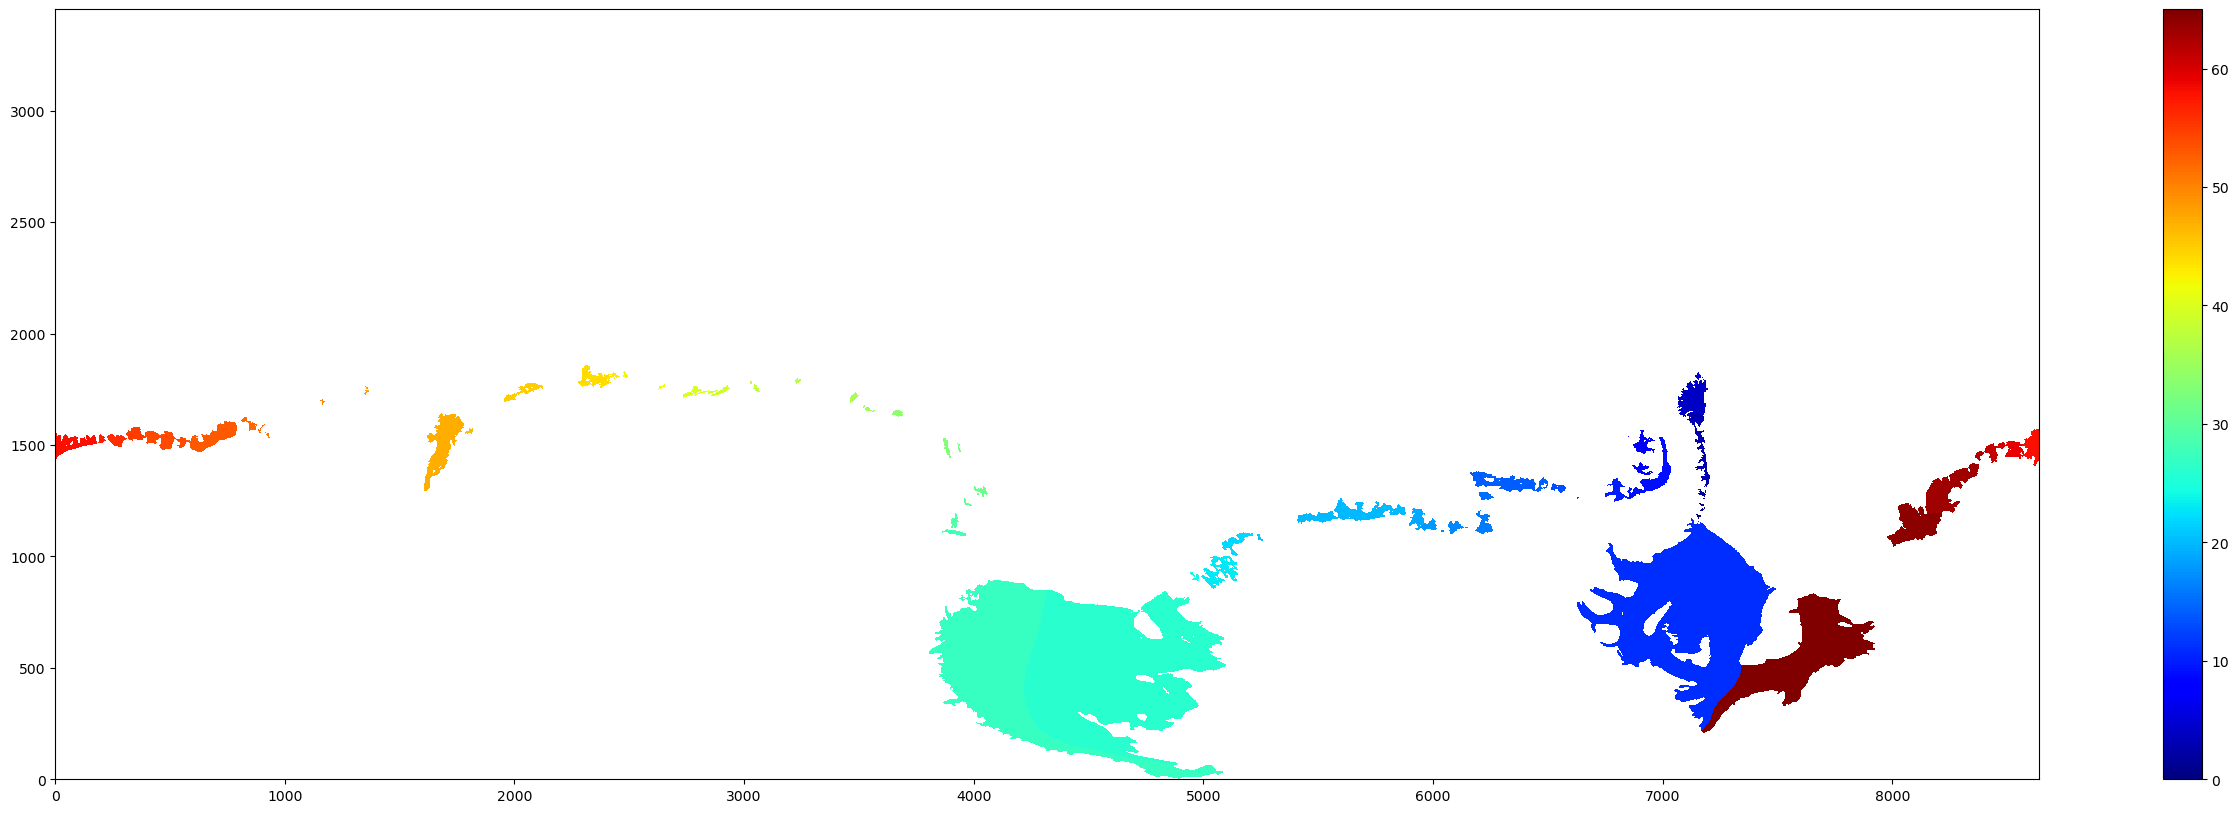

In [6]:
fig, ax = plt.subplots(figsize=(32,10))

im = ax.pcolormesh(data, cmap='jet') 


# im = ax.pcolormesh(ICESHELVES[1100:1200, 6100: 6300], vmin=1, cmap='jet') 

# ax.scatter(106, 54)
plt.colorbar(im)

In [7]:
np.save("ISmask_v3.npy", data)

### Manual Review

In [3]:
ISmask1 = np.load('Meta_Data/Ice_Draft.npy')
ISmask1[ISmask1!=0] = 1

ISmask2 = np.load("ISmask_v3.npy")

GRID = h5py.File('/Volumes/Project/SOhi_Data/GRID_v8.mat')
XC = np.asarray(GRID['XC'][0,:])
XC = ((XC + 180) %360) - 180
YC = np.asarray(GRID['YC'][:, 0])

In [4]:
def plot():
    
    iy1 = np.argmin(abs(YC - lat[0]))
    iy2 = np.argmin(abs(YC - lat[1]))
    ix1 = np.argmin(abs(XC - lon[0]))
    ix2 = np.argmin(abs(XC - lon[1]))

    fig, ax = plt.subplots(figsize=(10,5), ncols=2, sharey=True) 

    ax[0].pcolormesh(ISmask1[iy1:iy2, ix1:ix2])
    im = ax[1].pcolormesh(ISmask2[iy1:iy2, ix1:ix2])
    plt.tight_layout()
    plt.colorbar(im, ax=(ax[0], ax[1]))

    print(iy1, iy2, ix1, ix2)

1161 1197 7144 7168


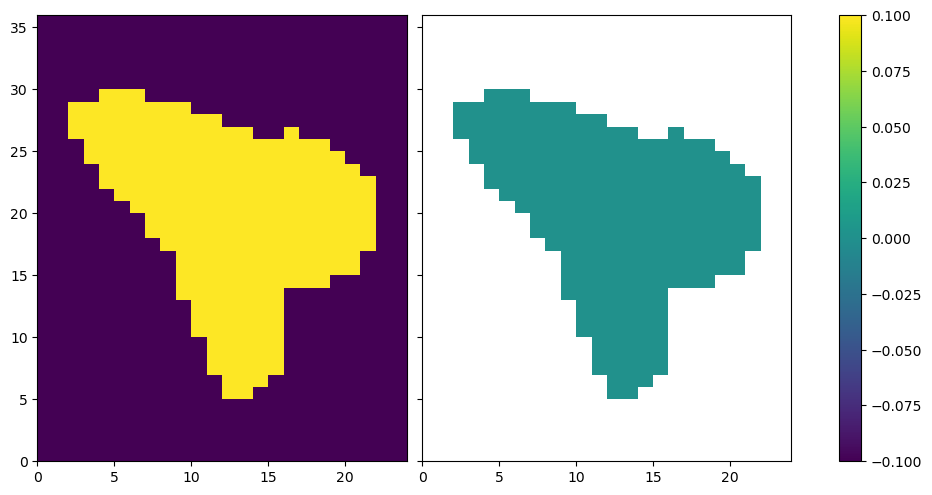

In [5]:
lat = [-74.8, -74.4]
lon = [-62.3, -61.3]

plot()

1201 1245 7156 7187


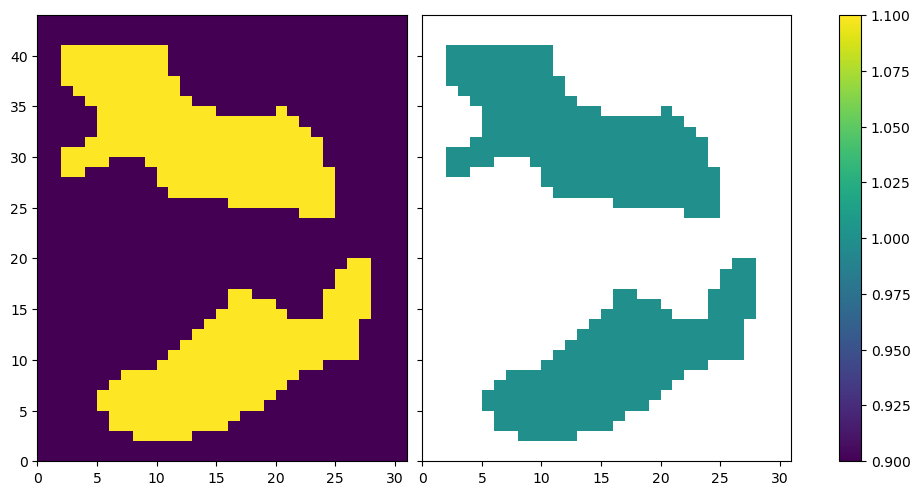

In [57]:
lat = [-74.35,-73.85]
lon = [-61.8, -60.5]

plot()

1254 1308 7151 7199


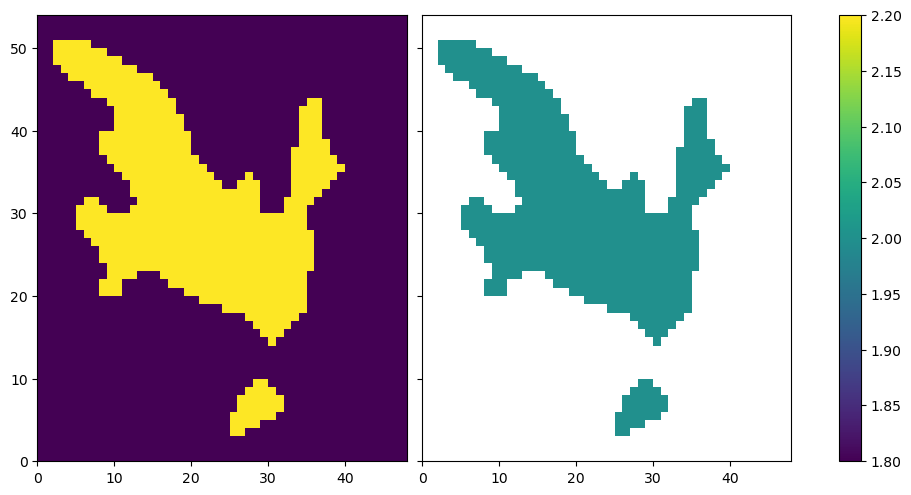

In [58]:
lat = [-73.75, -73.1]
lon = [-62, -60]

plot()

1307 1801 7060 7211


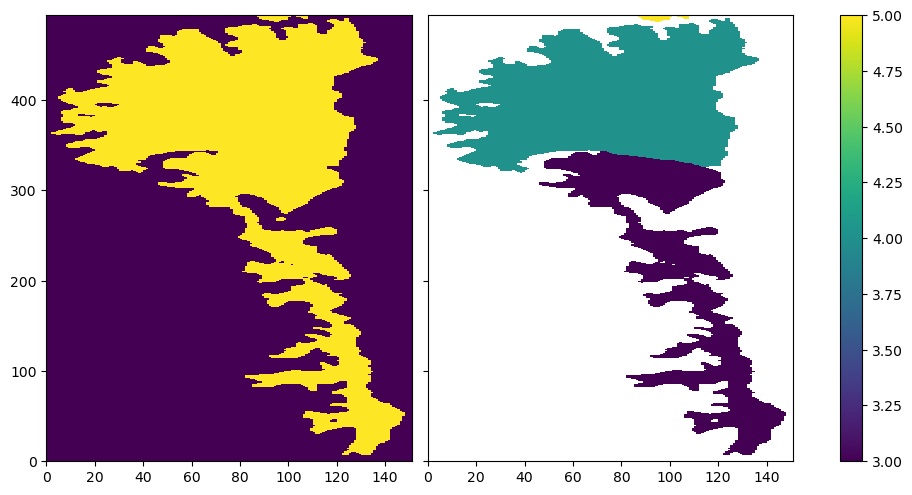

In [59]:
lat = [-73.12, -66]
lon = [-65.8, -59.5 ]
plot()

1789 1836 7139 7178


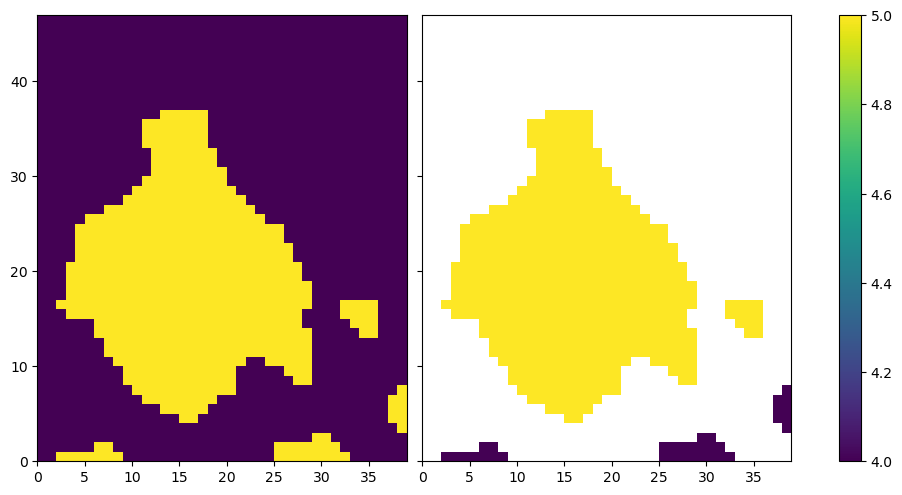

In [60]:
lat = [-66.2, -65.4  ]
lon = [-62.5, -60.9  ]
plot()

1579 1626 6995 7043


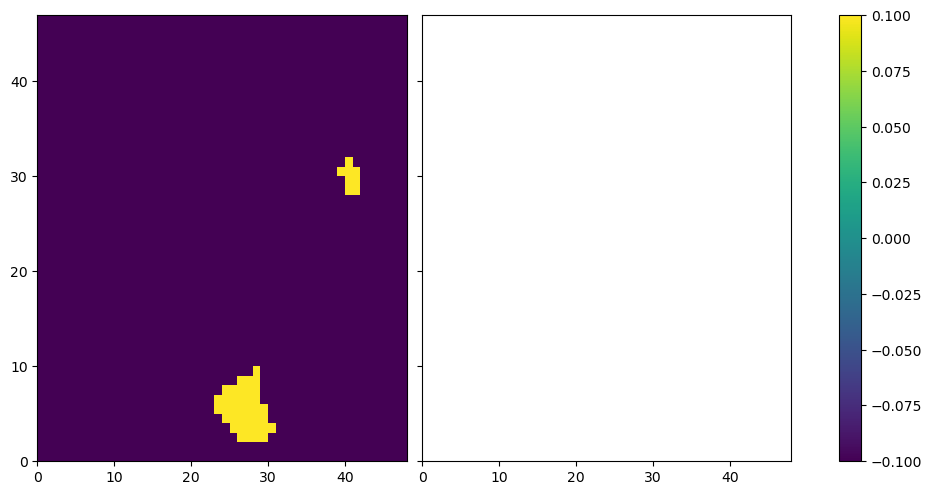

In [61]:
lat = [-69.5, -68.8  ]
lon = [-68.5, -66.5  ] 
plot()

1457 1579 6839 6971


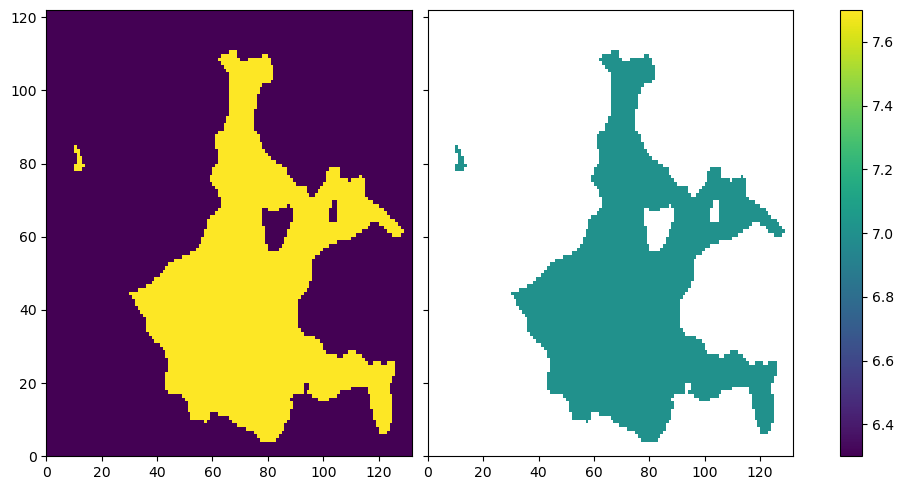

In [62]:
lat = [-71.2, -69.5  ]
lon = [-75, -69.5] 
plot()

1357 1431 6866 6959


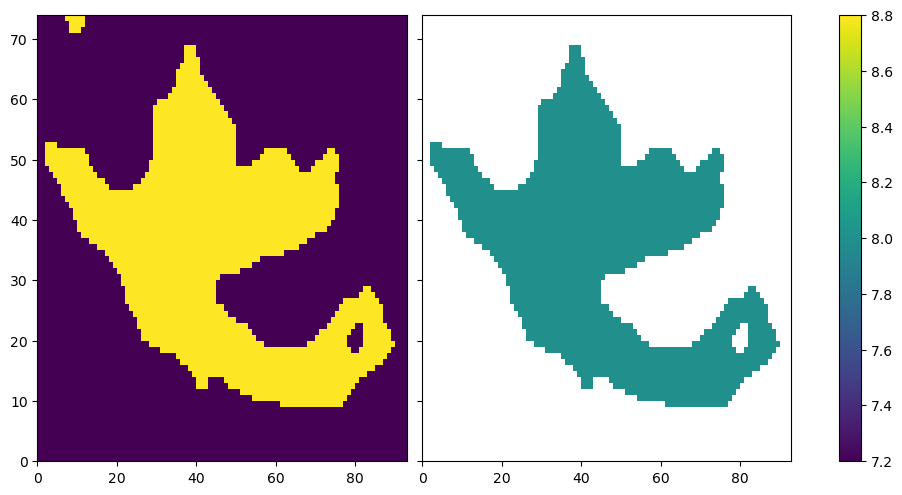

In [63]:
lat = [-72.5, -71.55 ] 
lon = [-73.9, -70  ] 
plot()

1232 1544 6839 7043


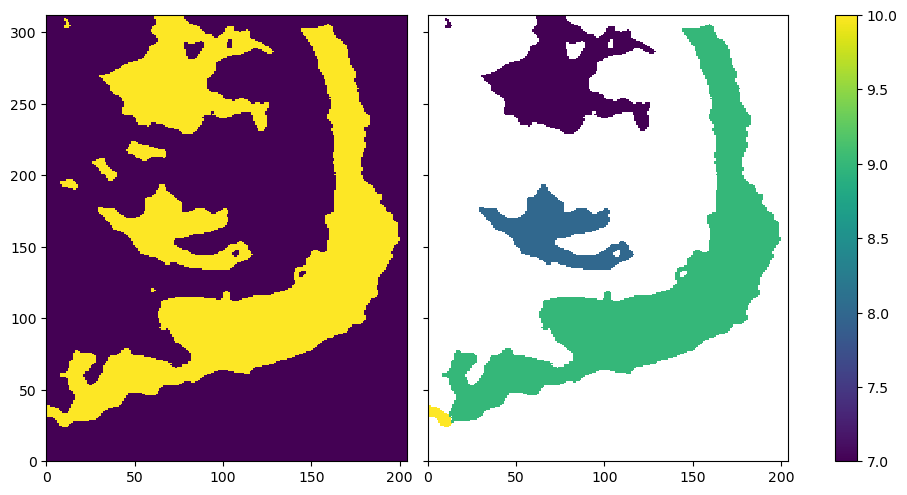

In [64]:
lat = [-74,-70]
lon = [-75, -66.5] 
plot()

1232 1357 6743 6863


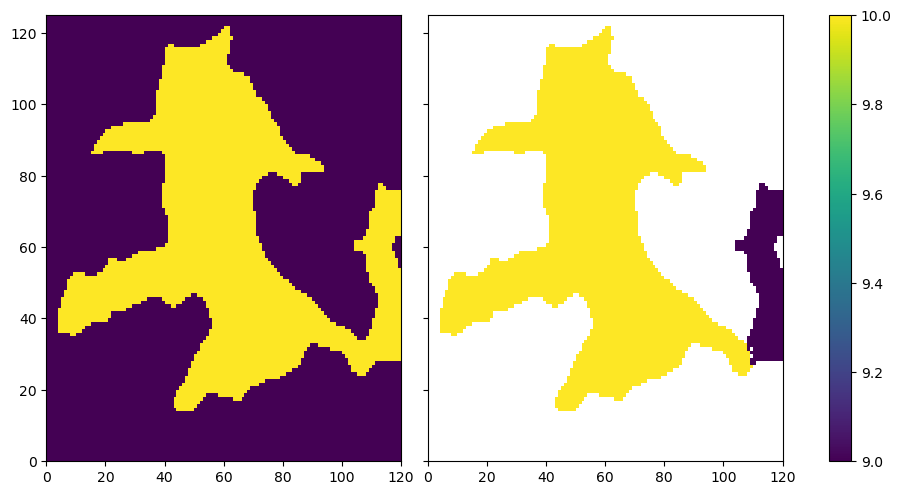

In [65]:
lat = [-74, -72.5 ]
lon = [-79, -74  ] 
plot()


0 1188 6611 7967


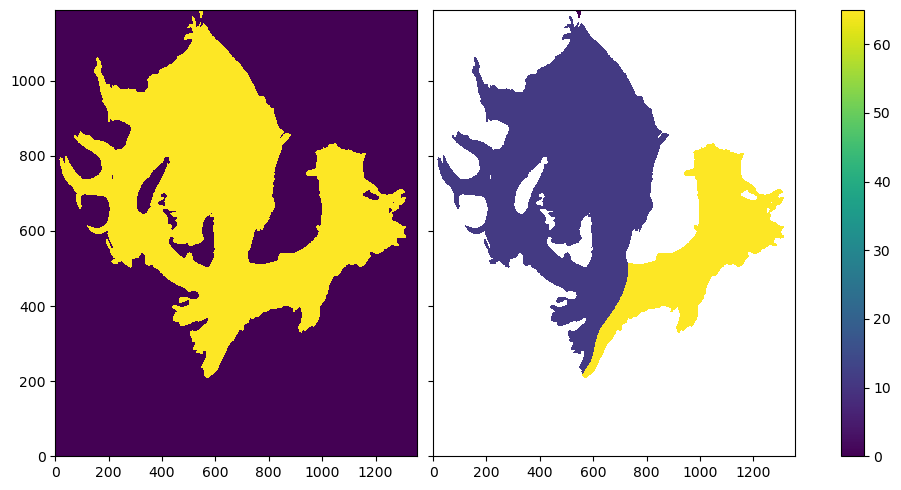

In [66]:
lat = [-85.5,-74.5]
lon = [-84.5,-28]
plot()

1254 1275 6623 6647


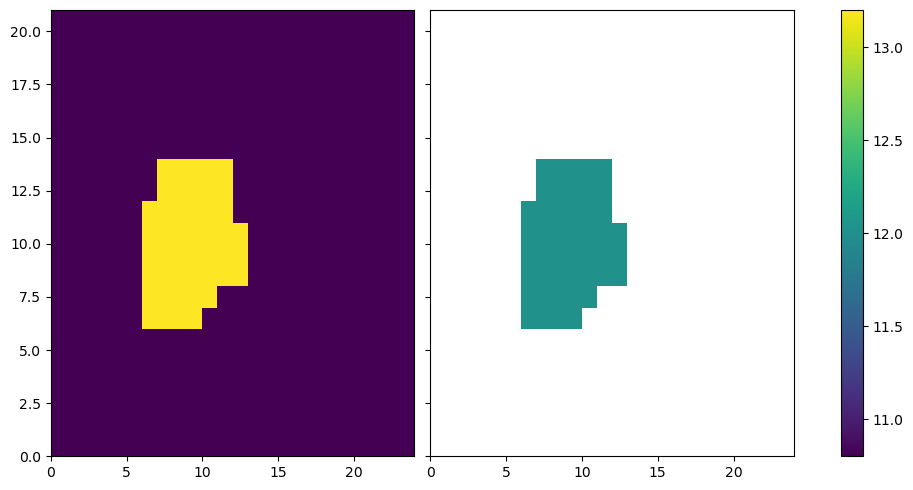

In [7]:
lat = [-73.75, -73.5  ]
lon = [-84, -83  ] 
plot()

1275 1333 6508 6581


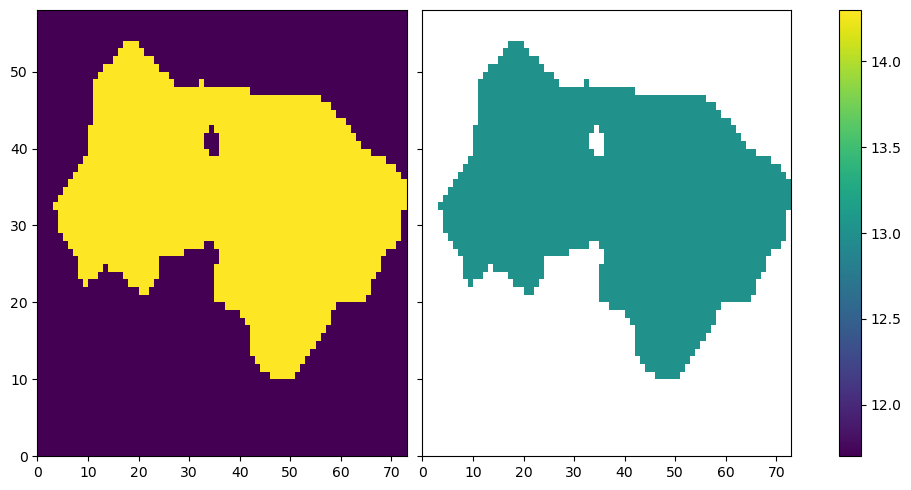

In [9]:
lat = [-73.5, -72.8  ]
lon = [-88.8, -85.75  ]
plot()

1275 1396 6151 6507


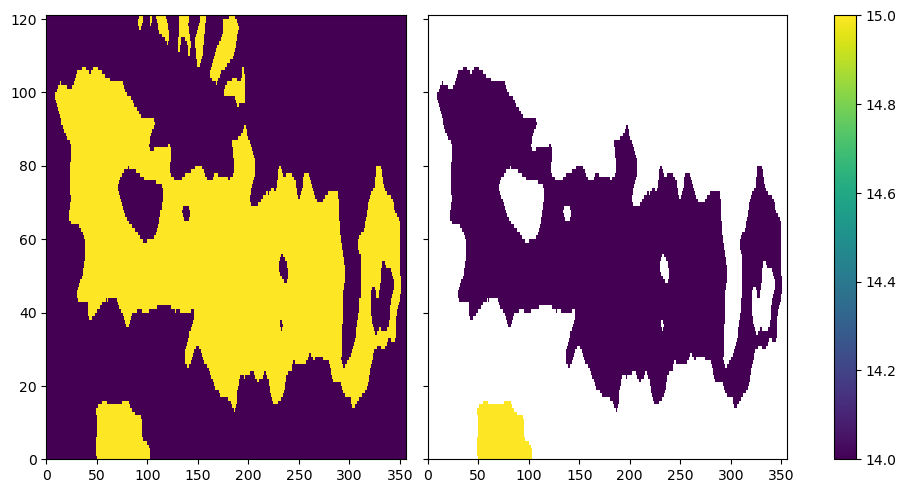

In [10]:
lat = [-73.5, -72  ]
lon = [-103.7, -88.85 ]
plot()

1241 1300 6196 6273


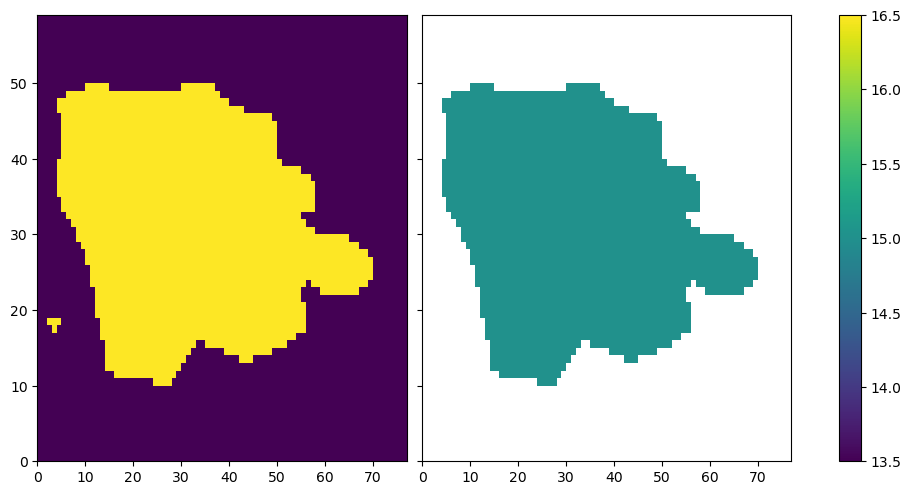

In [11]:
lat = [-73.9, -73.2  ]
lon = [-101.8, -98.6  ]
plot()

1095 1214 6167 6263


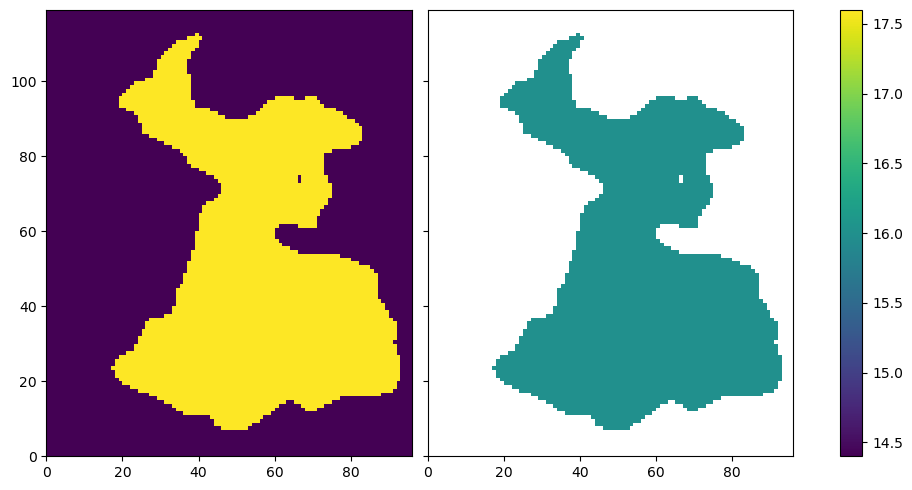

In [12]:
lat = [-75.5, -74.2]
lon = [-103, -99] 
plot()

1095 1188 6052 6158


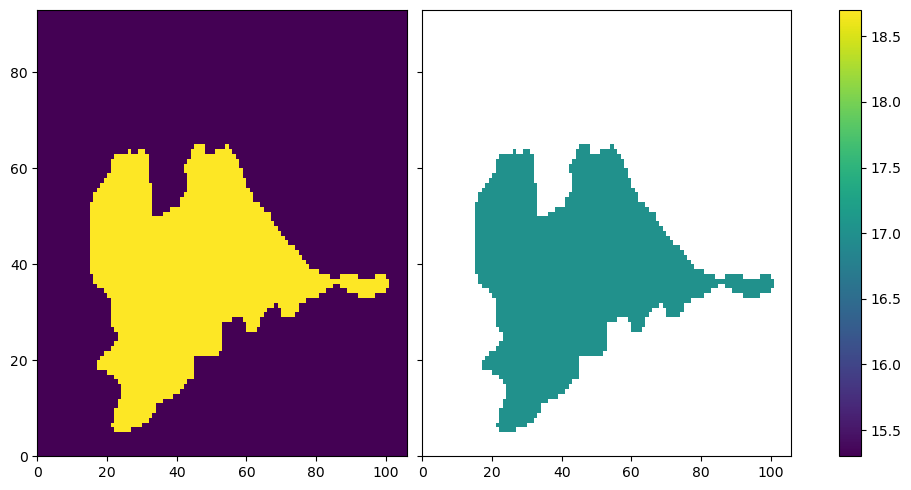

In [13]:
lat = [-75.5, -74.5]
lon = [-107.8, -103.4]
plot()

1095 1218 5884 6026


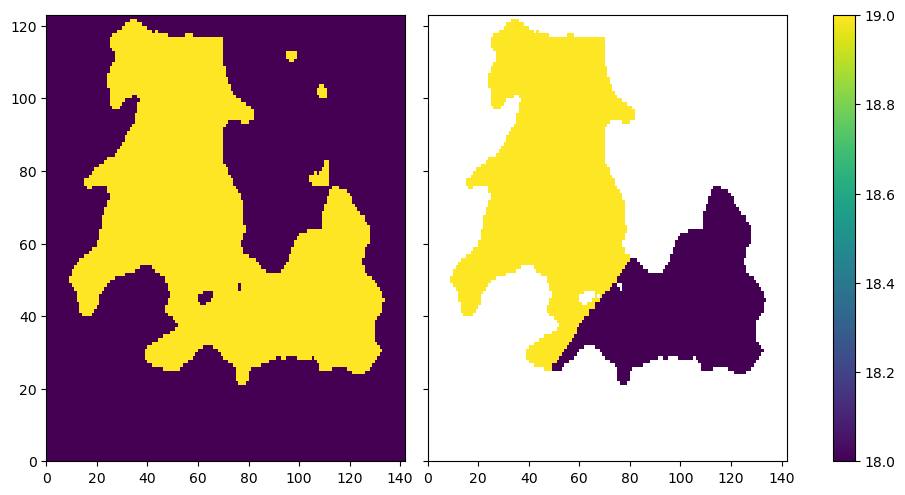

In [15]:
lat = [-75.5, -74.16  ]
lon = [-114.8, -108.9] 
plot()

1133 1317 5399 5891


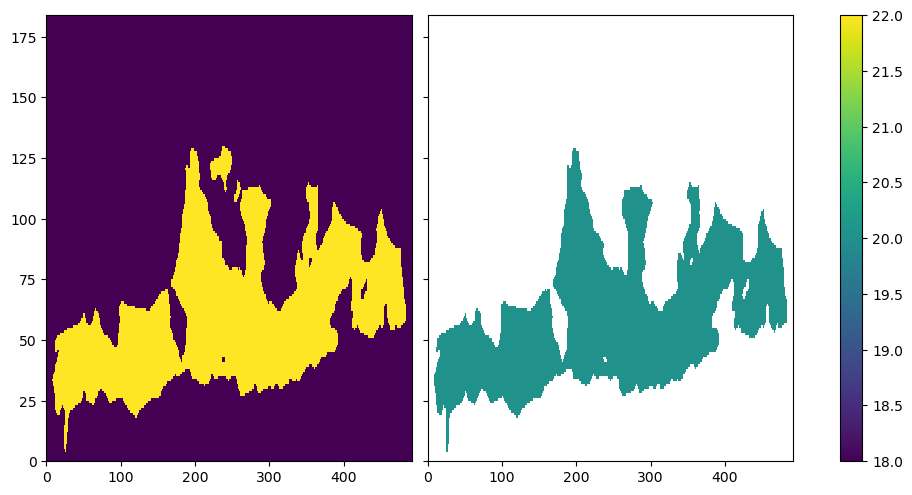

In [16]:
lat = [-75.1, -73]
lon = [-135, -114.5] 
plot()

1056 1105 5231 5261


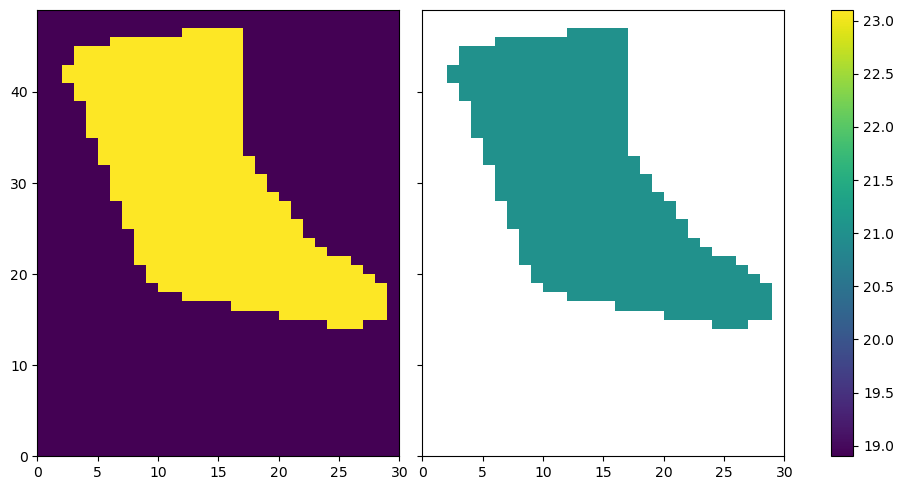

In [17]:
lat = [-75.9, -75.4  ]
lon = [-142, -140.75  ]
plot()

996 1133 5075 5222


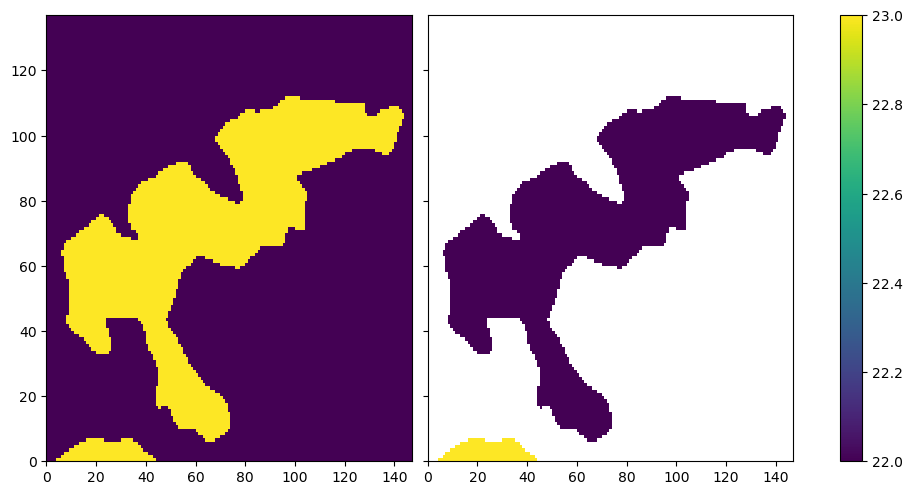

In [18]:
lat = [-76.5, -75.1  ]
lon = [-148.5,-142.4  ]
plot()

845 1006 4982 5159


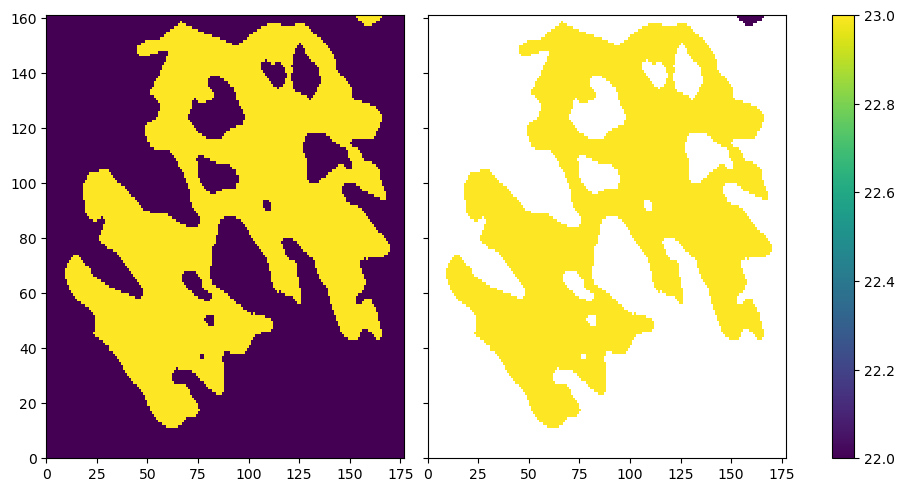

In [19]:
lat = [-77.9, -76.4 ]
lon = [-152.4, -145  ]
plot()

878 943 4931 4982


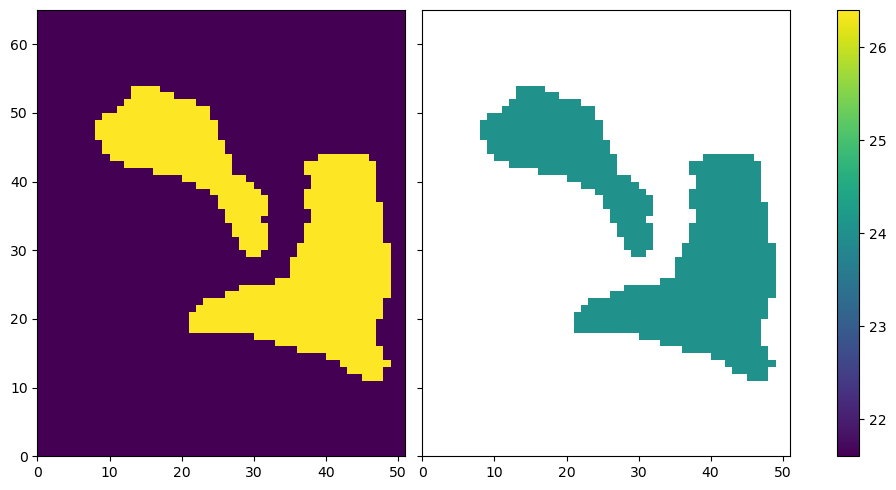

In [20]:
lat = [ -77.6, -77 ]
lon = [-154.5, -152.4  ]
plot()

889 965 4855 4886


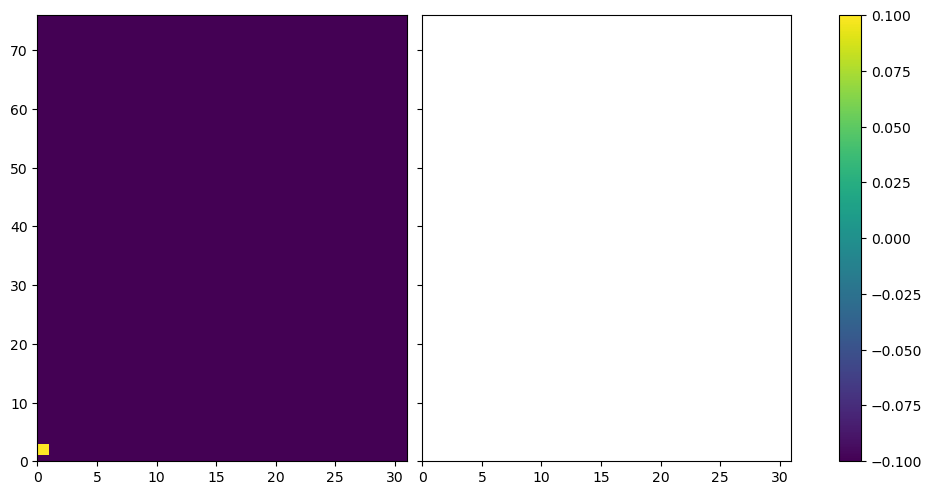

In [21]:
lat = [-77.5, -76.8  ]
lon = [-157.7, -156.4  ] 
plot()

0 845 4322 5111


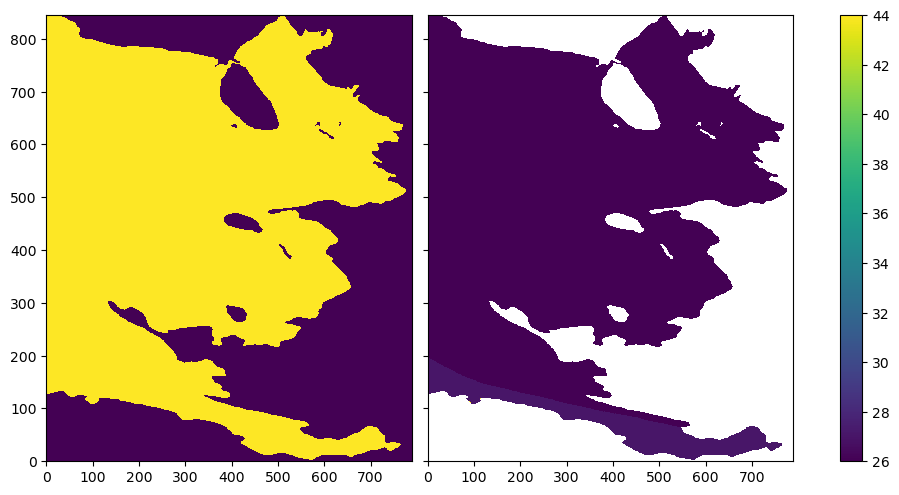

In [22]:
lat = [-85.5, -77.9  ]
lon = [-179.9, -147]
plot()

0 917 3800 4318


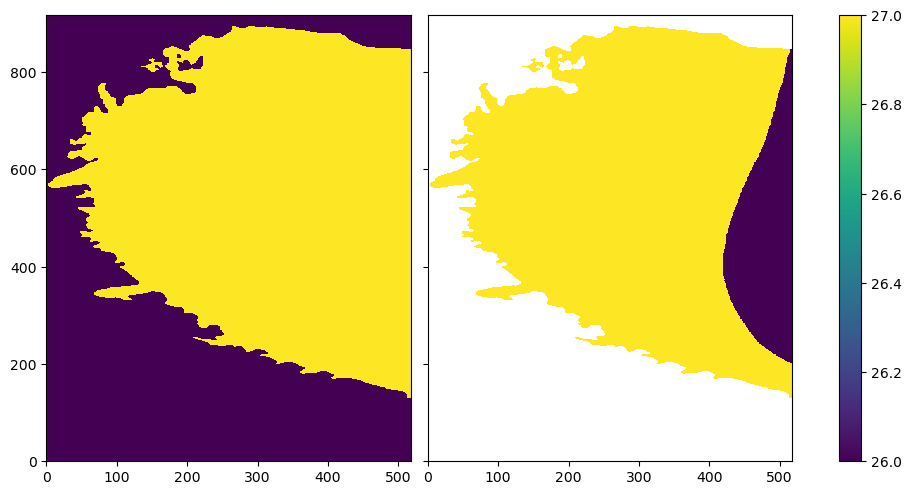

In [23]:
lat = [-85.5, -77.25]
lon = [158.35,179.95]
plot()

1066 1133 3839 3971


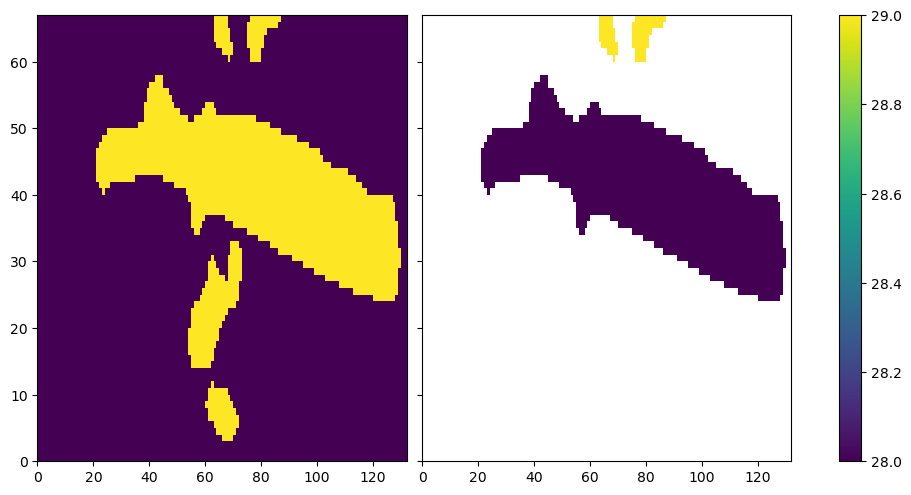

In [24]:
lat = [-75.8, -75.1]
lon = [160, 165.5]
plot()

1124 1201 3897 3935


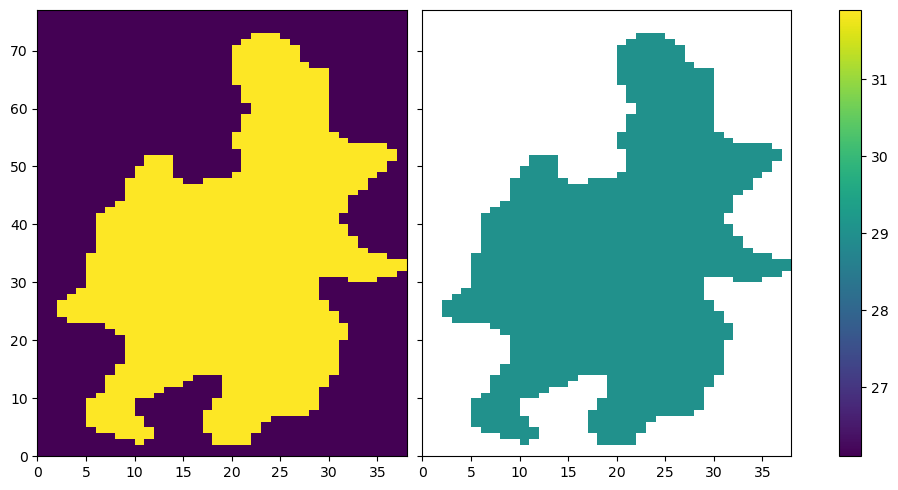

In [25]:
lat = [-75.2, -74.35]
lon = [162.4, 164]
plot()

1210 1266 3953 3993


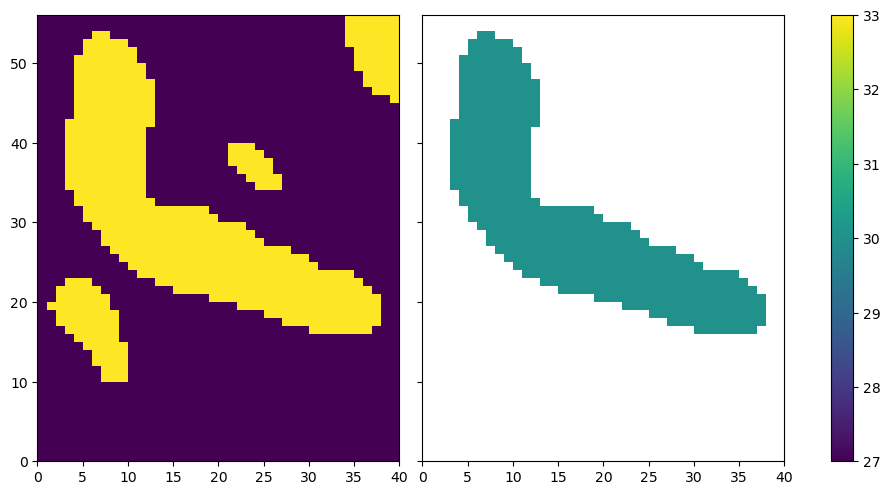

In [26]:
lat = [-74.25, -73.6]
lon = [164.75, 166.4]
plot()

1258 1325 3998 4063


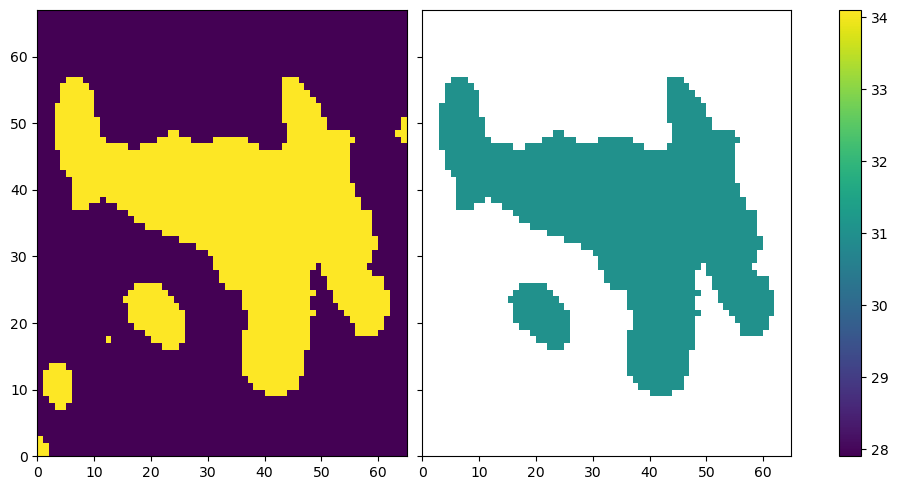

In [27]:
lat = [-73.7, -72.9]
lon = [166.6, 169.3]
plot()

1461 1516 3923 3945


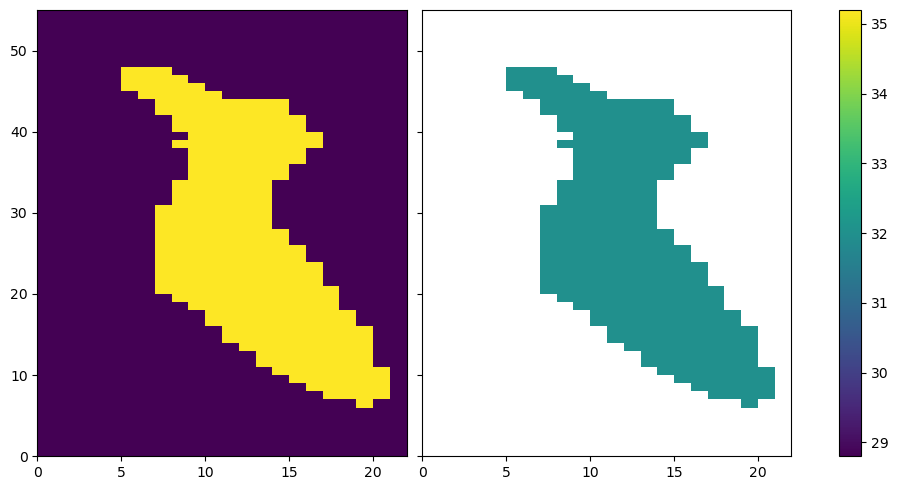

In [28]:
lat = [-71.15,-70.4]
lon = [163.5,164.4]
plot()

1435 1544 3861 3902


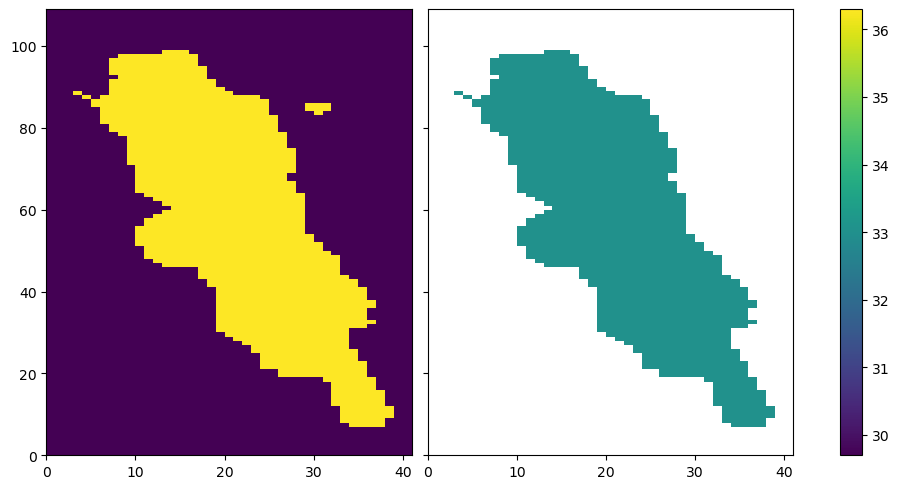

In [29]:
lat = [-71.5, -70]
lon = [160.9, 162.6]

plot()

1619 1672 3621 3695


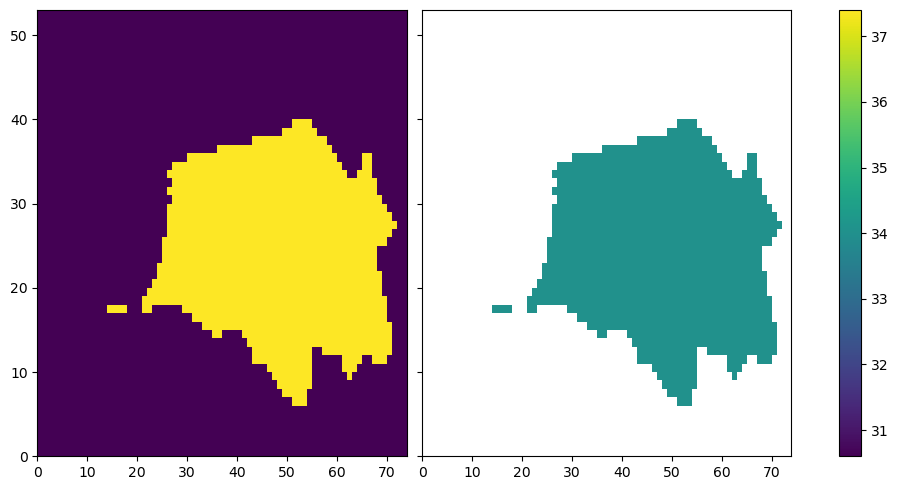

In [31]:
lat = [-68.9, -68.1]
lon = [150.9,154]
plot()

1642 1684 3515 3573


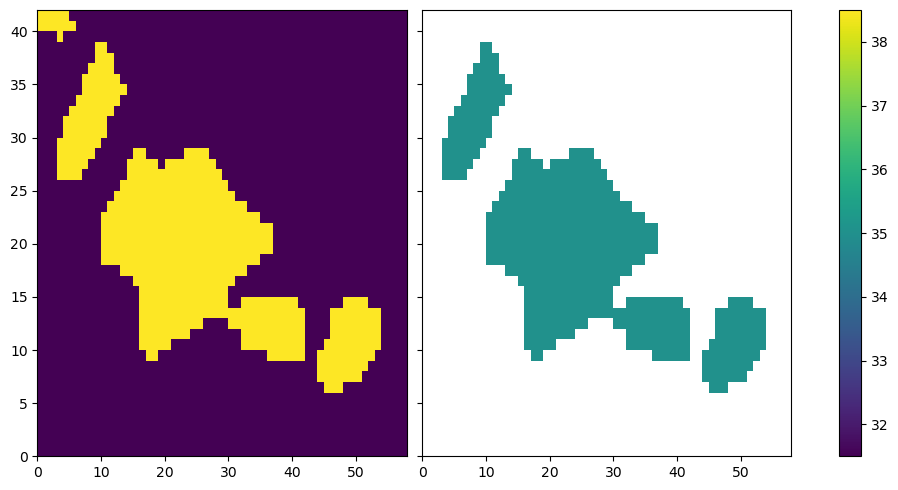

In [32]:
lat = [-68.55,-67.9]
lon = [146.5, 148.9]
plot()

1678 1771 3455 3503


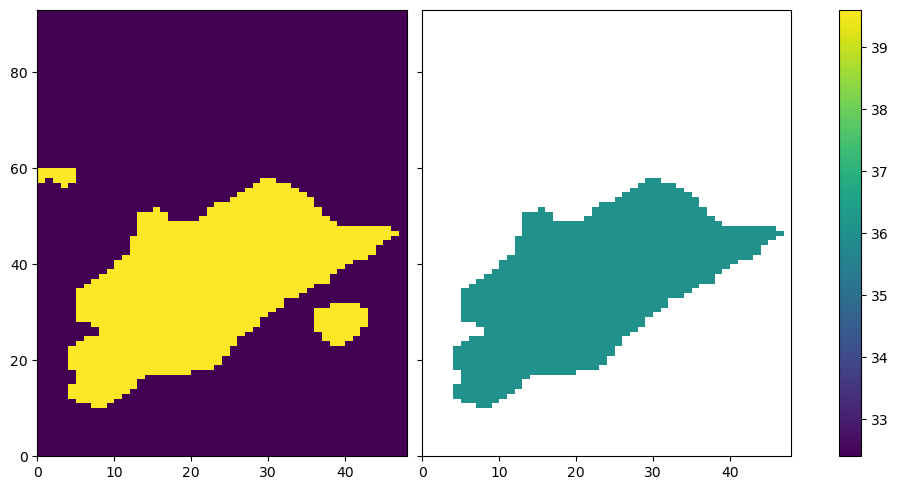

In [33]:
lat = [-68, -66.5]
lon = [144,146]

plot()

1771 1804 3215 3254


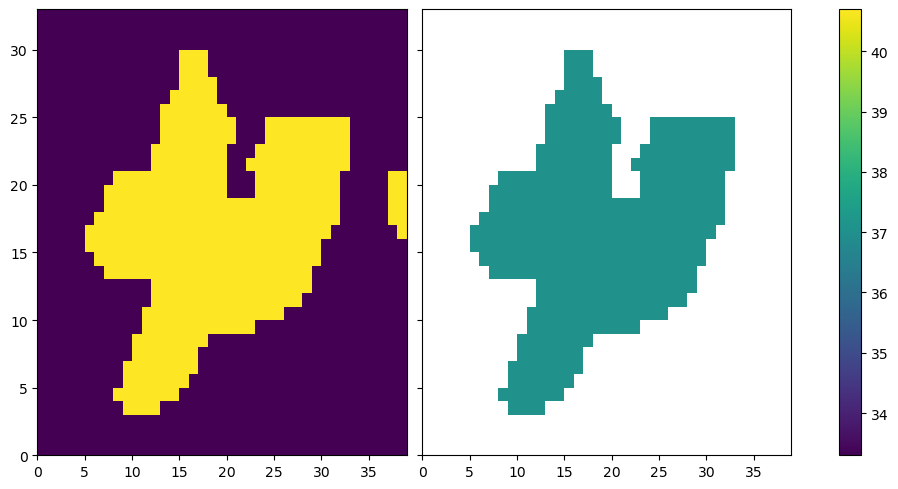

In [34]:
lat = [-66.5, -65.95]
lon = [134, 135.6]

plot()

1735 1789 3021 3071


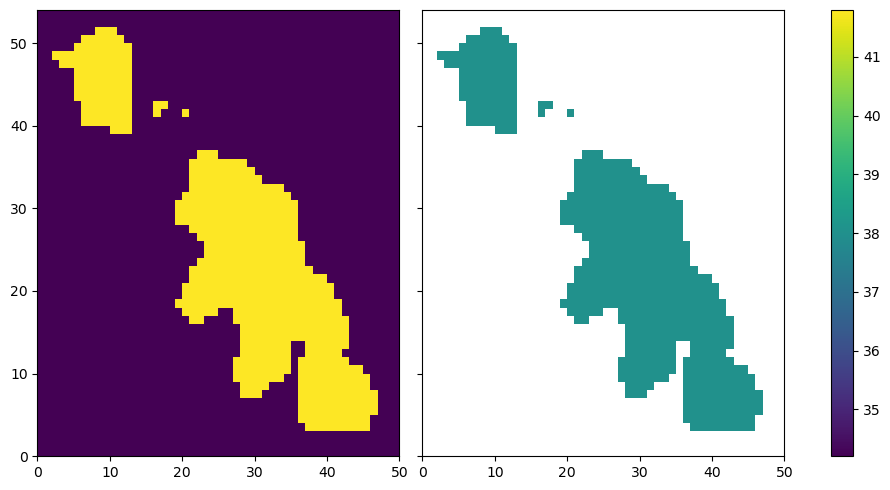

In [35]:
lat = [-67.1, -66.2]
lon = [125.9, 128]

plot()

1710 1774 2783 2943


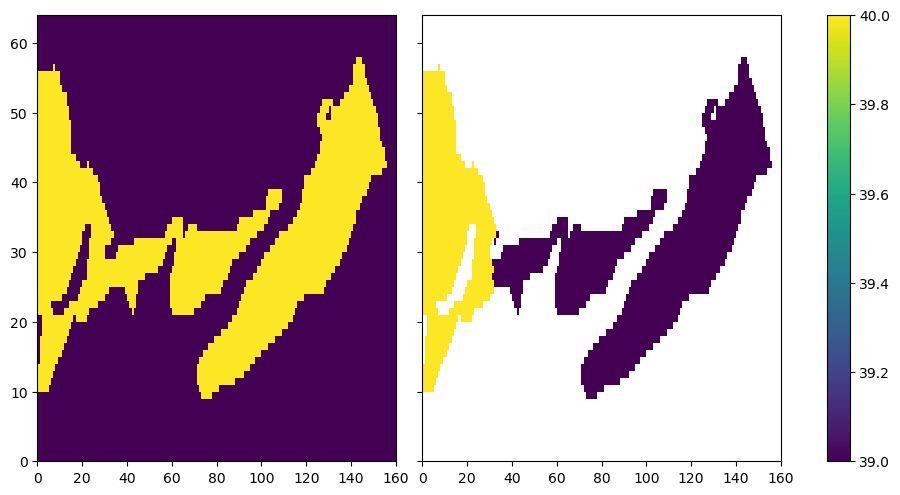

In [37]:
lat = [-67.5, -66.45]
lon = [116, 122.65]

plot()

1703 1771 2728 2855


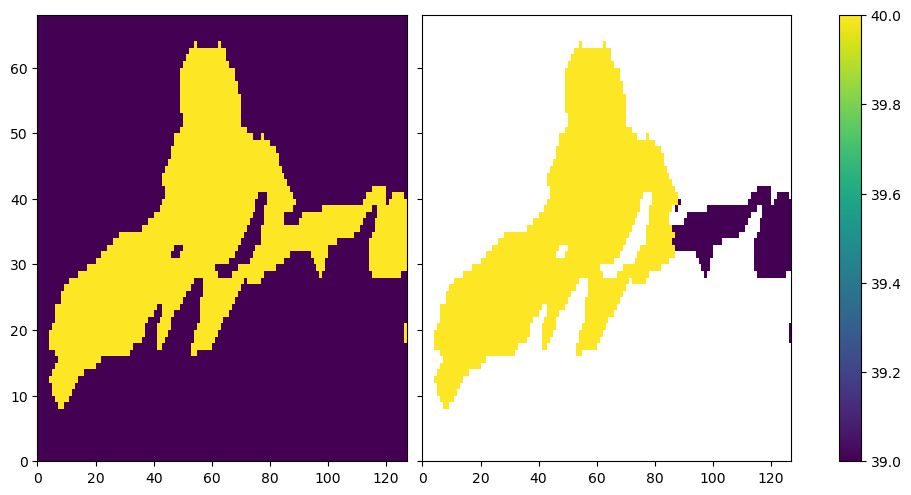

In [39]:
lat = [-67.6, -66.5]
lon = [113.7, 119]

plot()

1741 1775 2601 2663


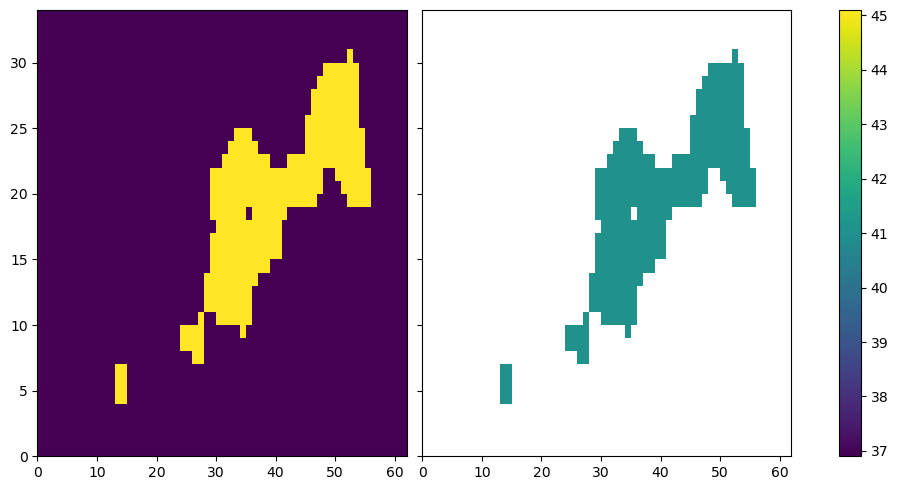

In [40]:
lat = [-67, -66.43]
lon = [108.4, 111] 

plot()

1798 1836 2468 2495


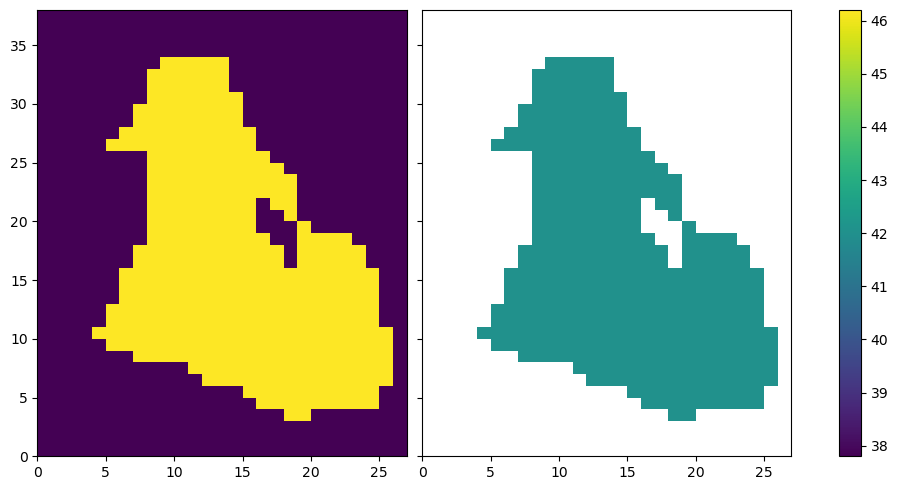

In [41]:
lat = [-66.05, -65.4]
lon = [102.85, 104]
plot()

1789 1845 2399 2463


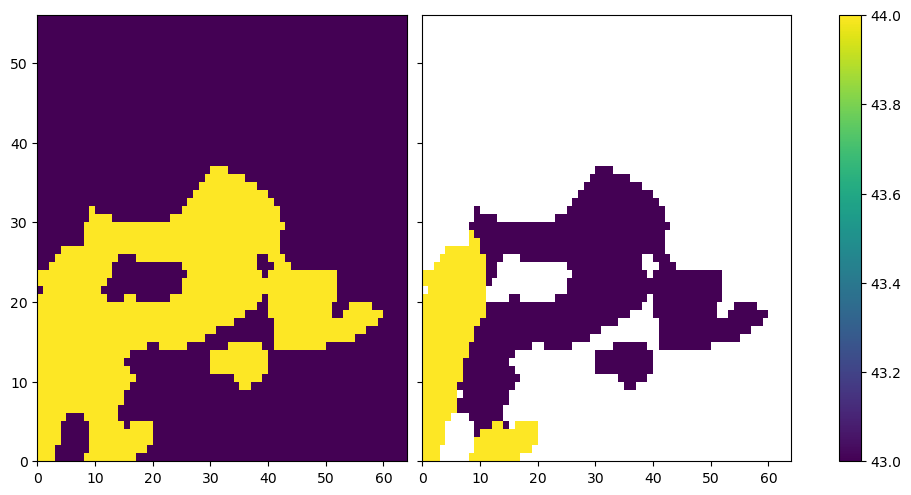

In [42]:
lat = [-66.2, -65.25]
lon = [100, 102.63]

plot()

1741 1864 2267 2423


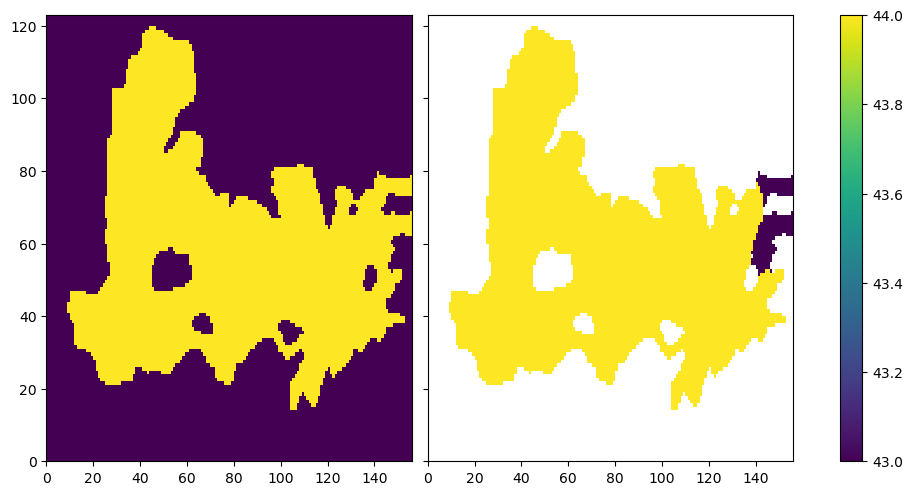

In [43]:
lat = [-67, -64.9]
lon = [94.5,101] 

plot()

1684 1789 1948 2135


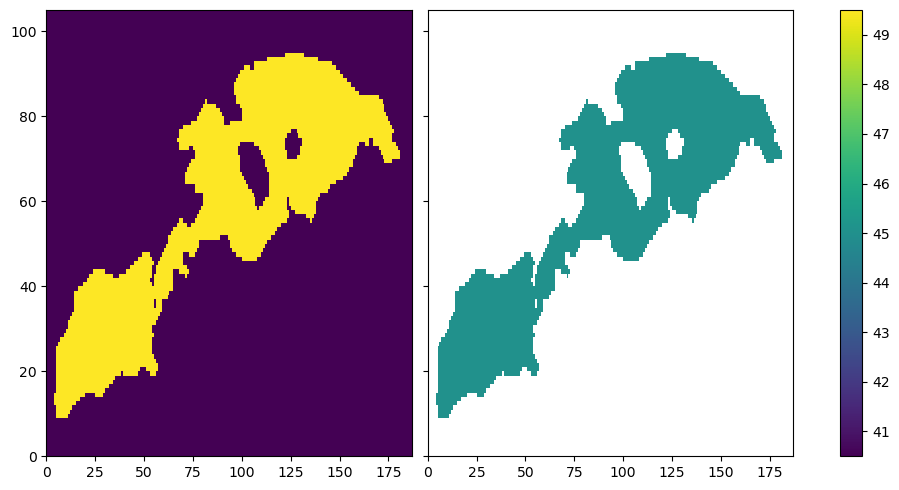

In [44]:
lat = [-67.9, -66.2]
lon = [81.2, 89]

plot()

1544 1579 1779 1823


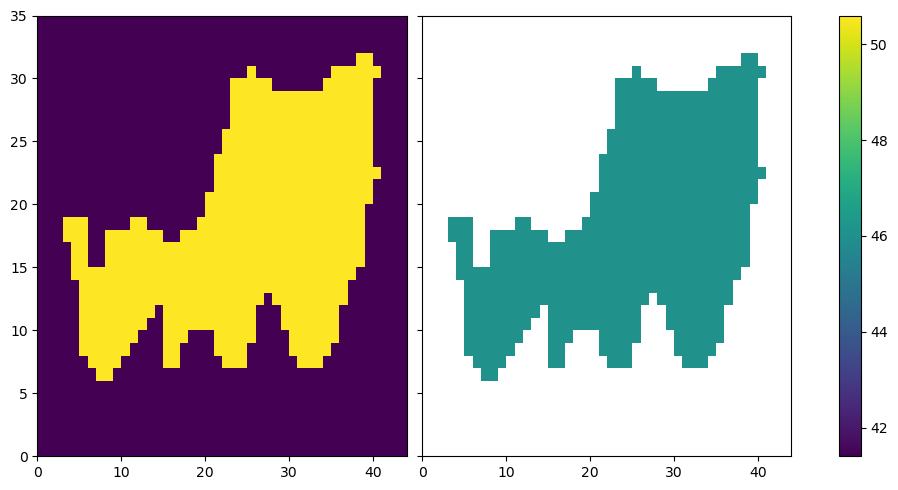

In [45]:
lat = [-70, -69.5 ]
lon = [74.15, 76]

plot()

1266 1665 1601 1790


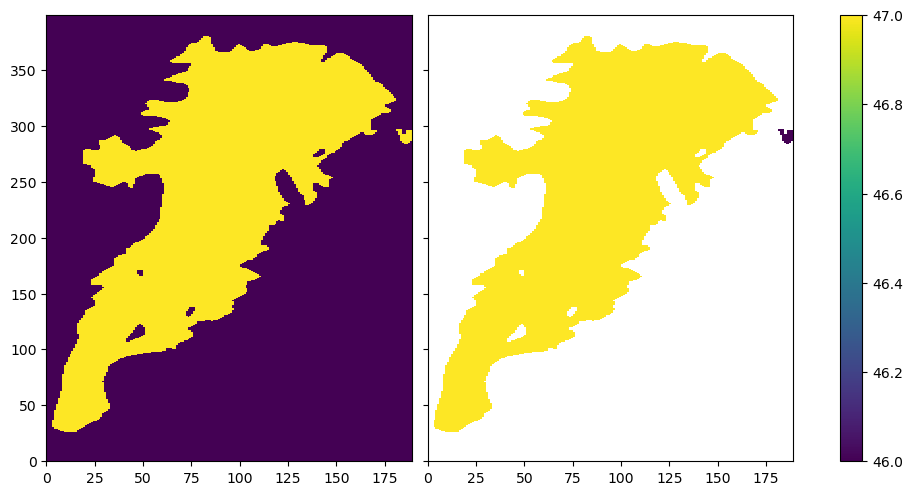

In [46]:
lat = [-73.6,-68.2]
lon = [66.75, 74.6]

plot()

1716 1748 1339 1370


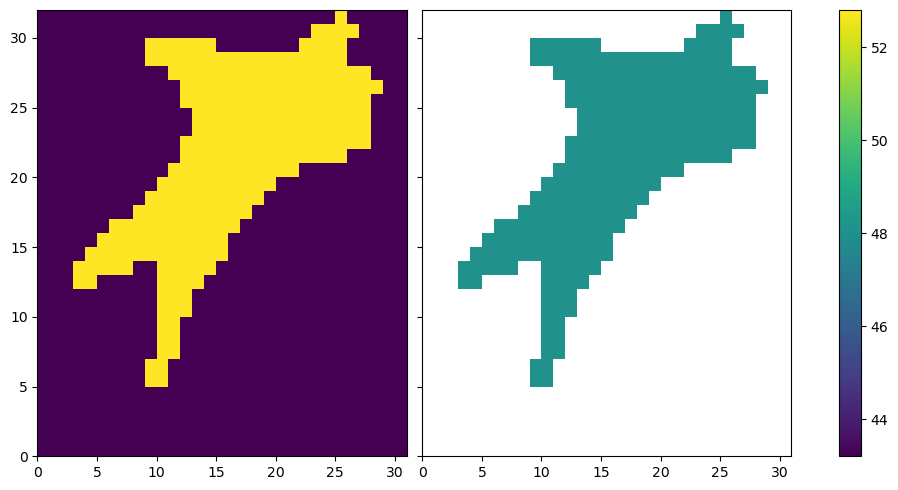

In [47]:
lat = [-67.4, -66.88]
lon = [55.8, 57.12]
plot()

1748 1770 1339 1370


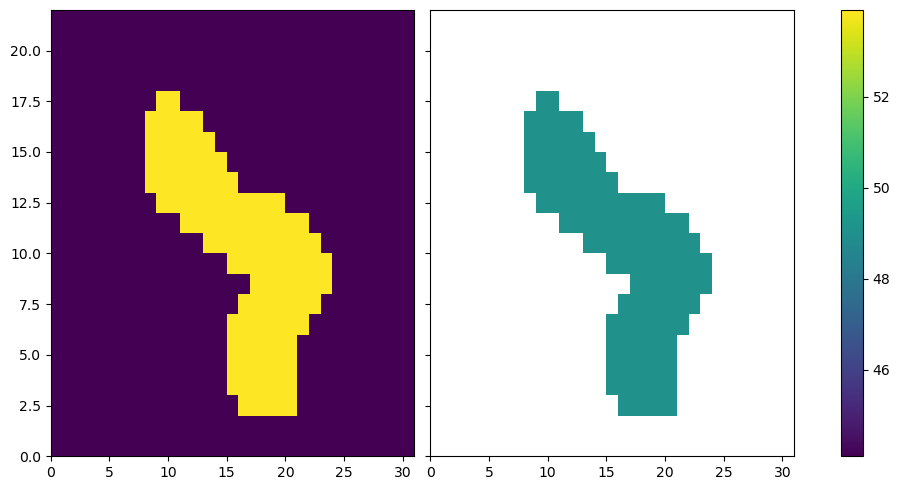

In [48]:
lat = [-66.88, -66.52]
lon = [55.8, 57.12]

plot()

1678 1710 1152 1178


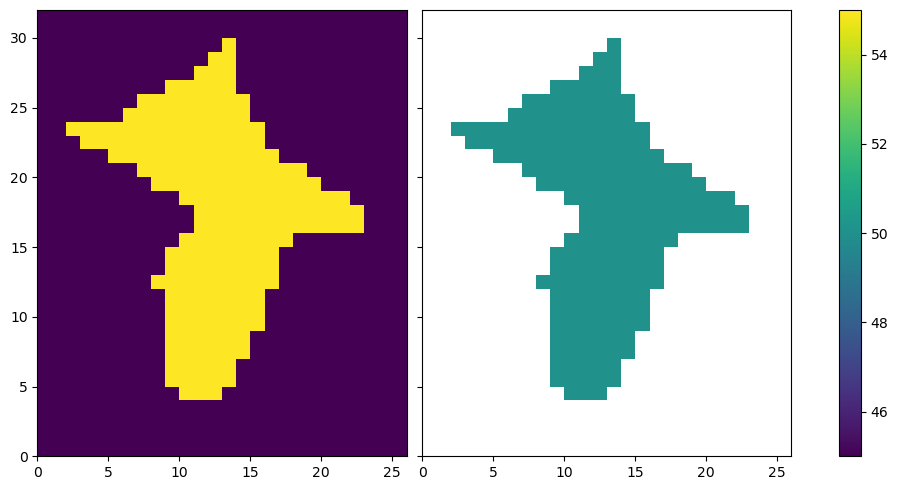

In [49]:
lat = [-68, -67.5]
lon = [48.02, 49.1]
plot()

1526 1565 911 938


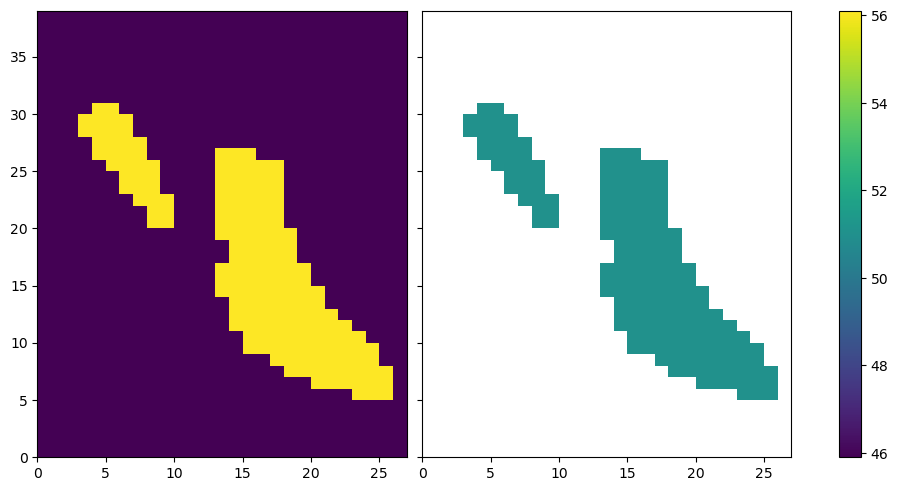

In [50]:
lat = [-70.25, -69.7]
lon = [38, 39.11]

plot()

1551 1632 806 916


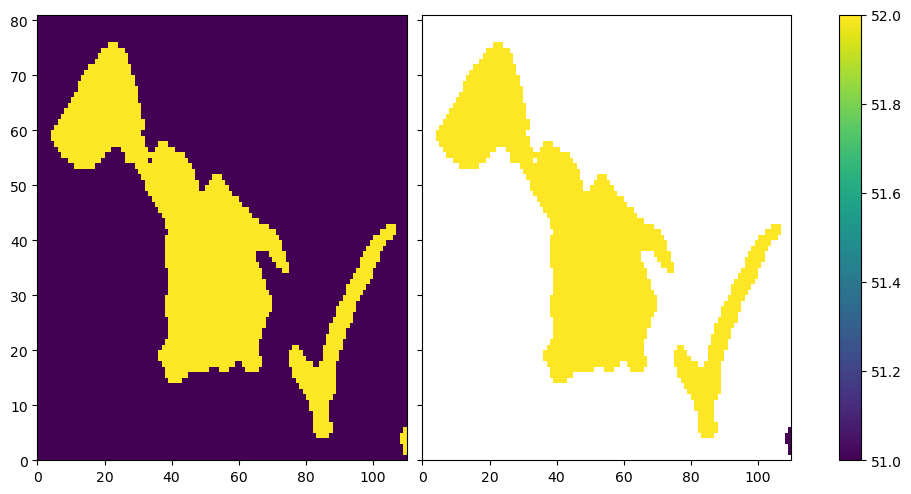

In [51]:
lat = [-69.9, -68.7]
lon = [33.6, 38.2]
plot()

1442 1629 479 799


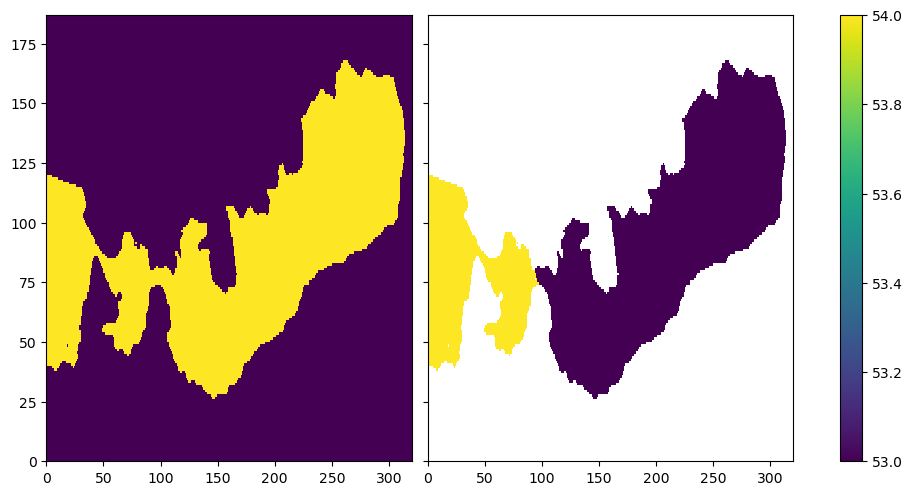

In [53]:
lat = [-71.4, -68.75]
lon = [20, 33.3]

plot()

1472 1572 359 599


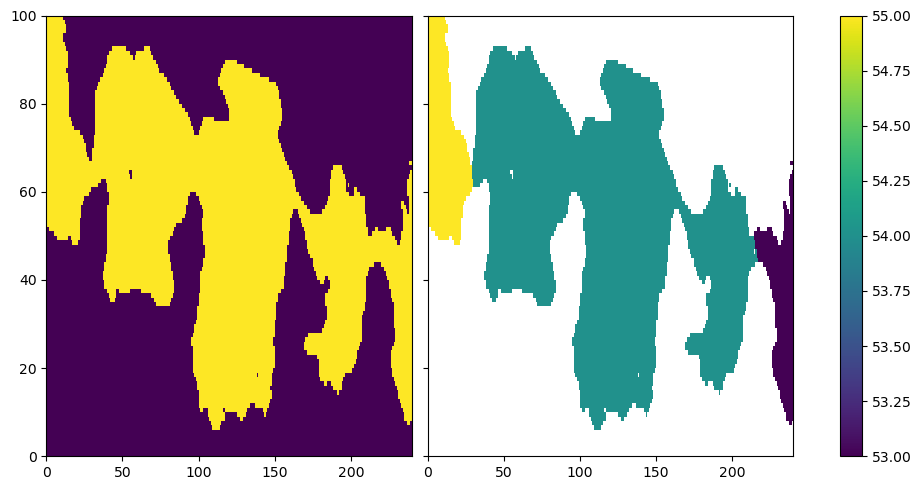

In [56]:
lat = [-71, -69.6]
lon = [15, 25]

plot()

1516 1585 305 407


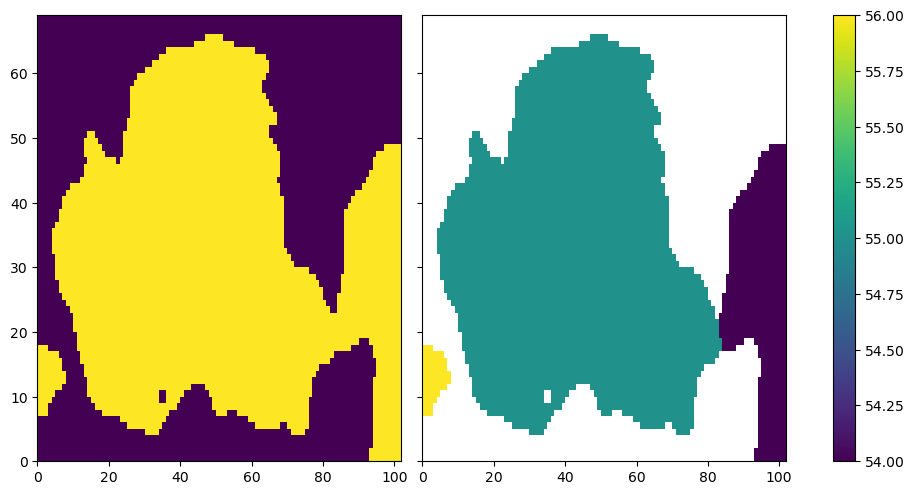

In [58]:
lat = [-70.4, -69.4]
lon = [12.75, 17]

plot()

1486 1551 220 315


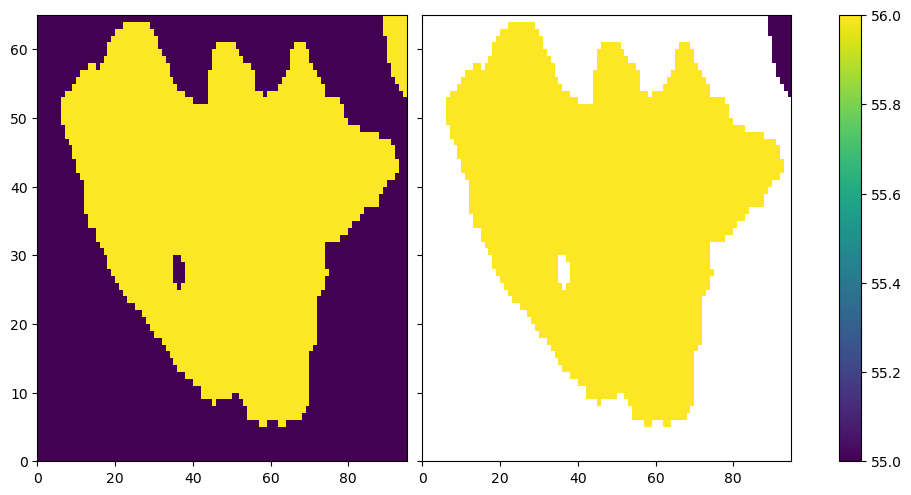

In [59]:
lat = [-70.81, -69.9]
lon = [9.2, 13.15]
plot()

1505 1558 183 223


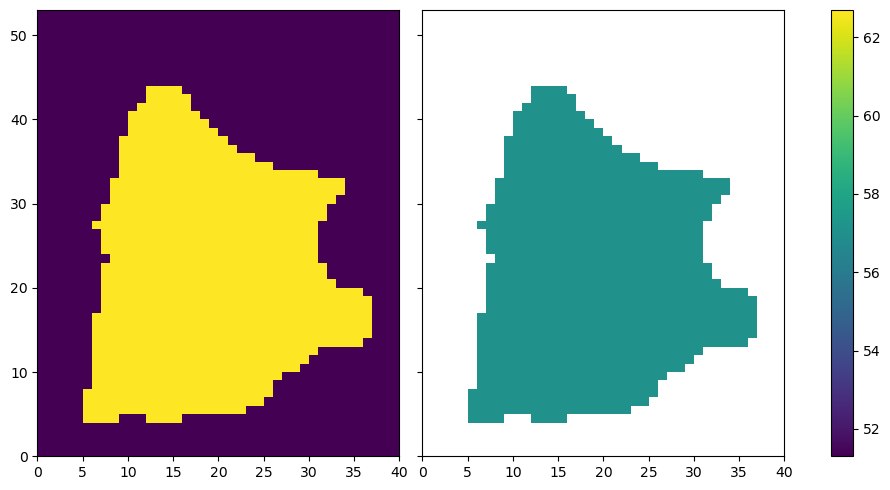

In [60]:
lat = [-70.55, -69.80]
lon = [7.65, 9.3]

plot()

1396 1579 1 215


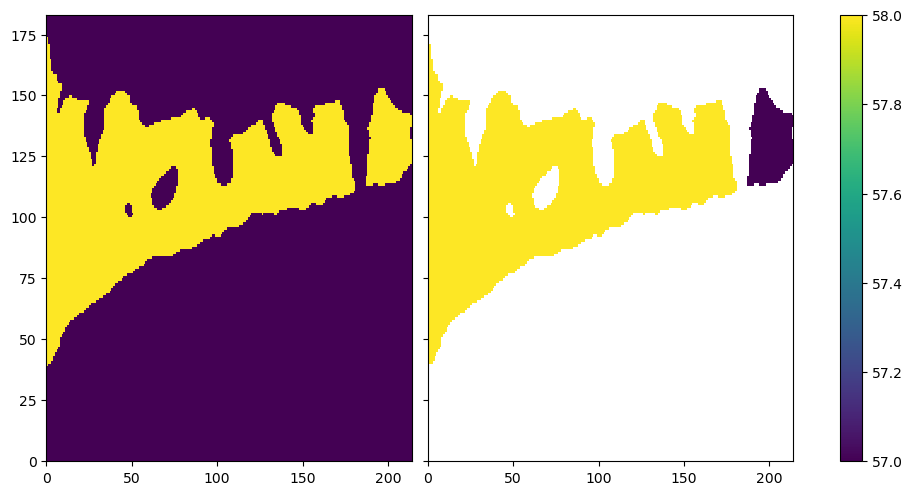

In [63]:
lat = [-72, -69.5]
lon = [0.05,9]

plot()

1396 1579 8519 8638


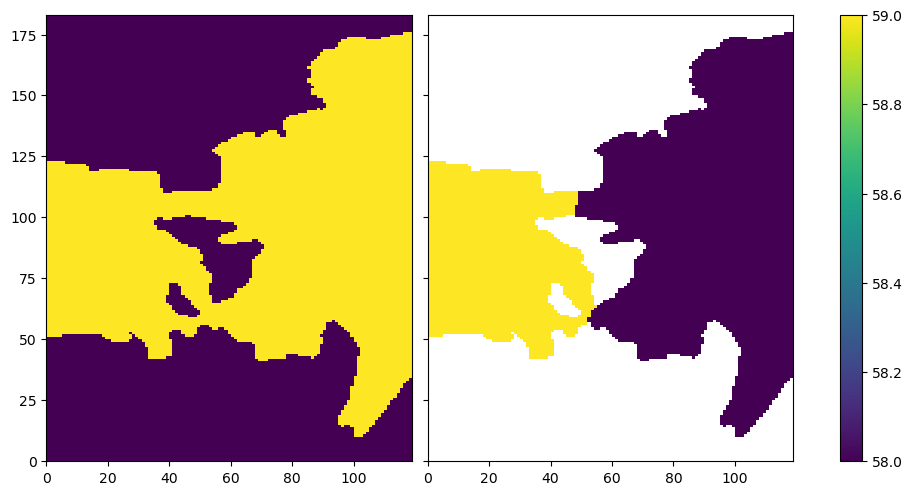

In [65]:
lat = [-72, -69.5]
lon = [-5, -0.05]
plot()

1427 1523 8483 8591


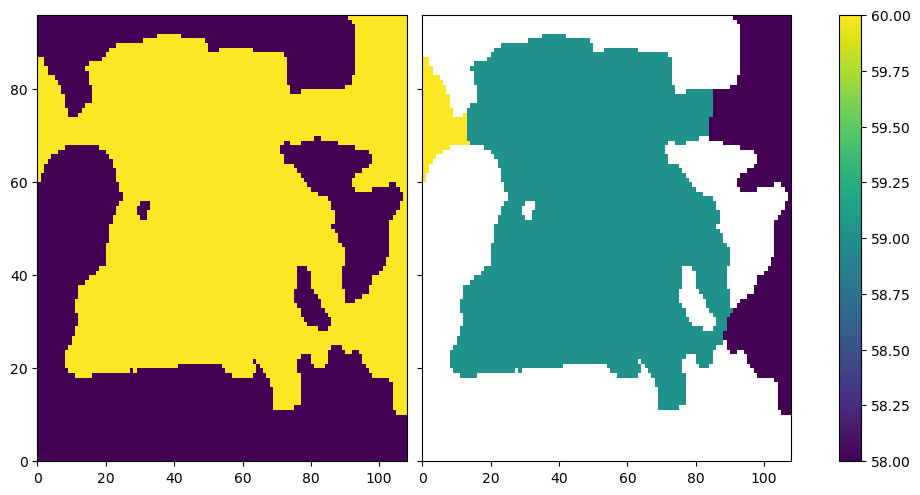

In [69]:
lat = [-71.6, -70.3]
lon = [-6.5, -2]
plot()

1472 1523 8447 8543


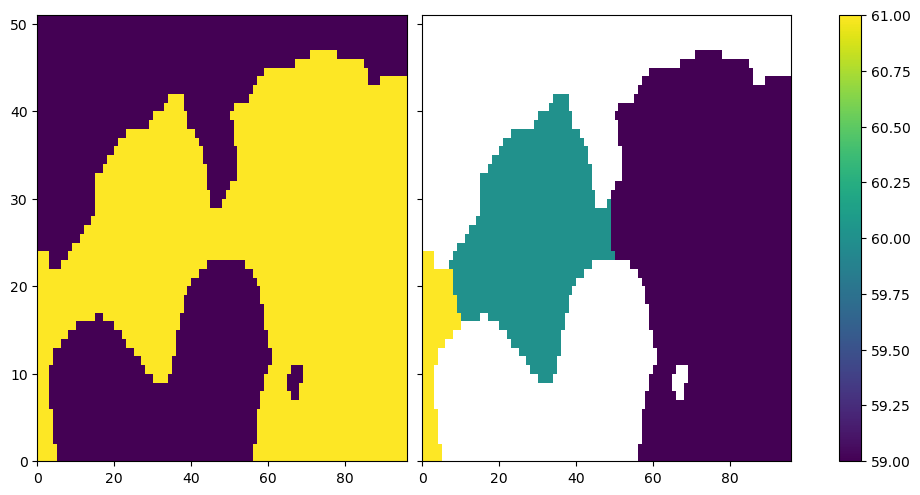

In [68]:
lat = [-71, -70.3]
lon = [-8, -4]

plot()

1412 1513 8397 8471


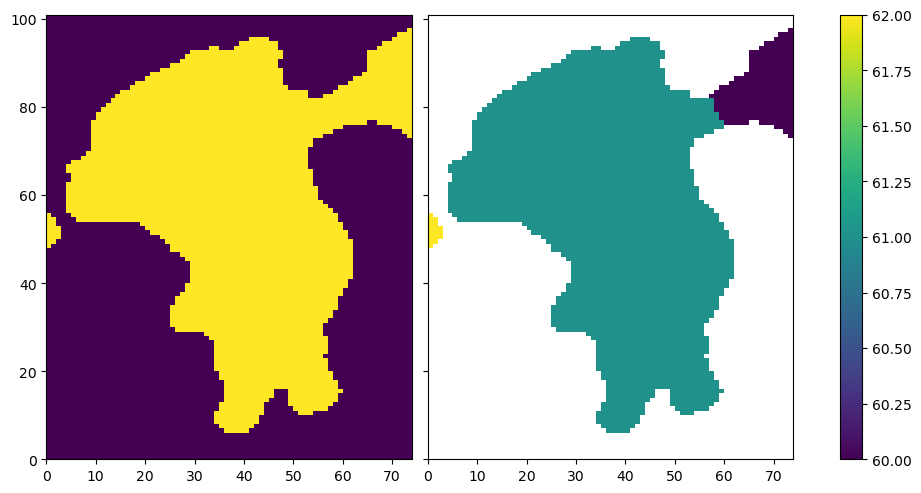

In [70]:
lat = [-71.8, -70.44]
lon = [-10.1, -7]

plot()

1421 1479 8356 8402


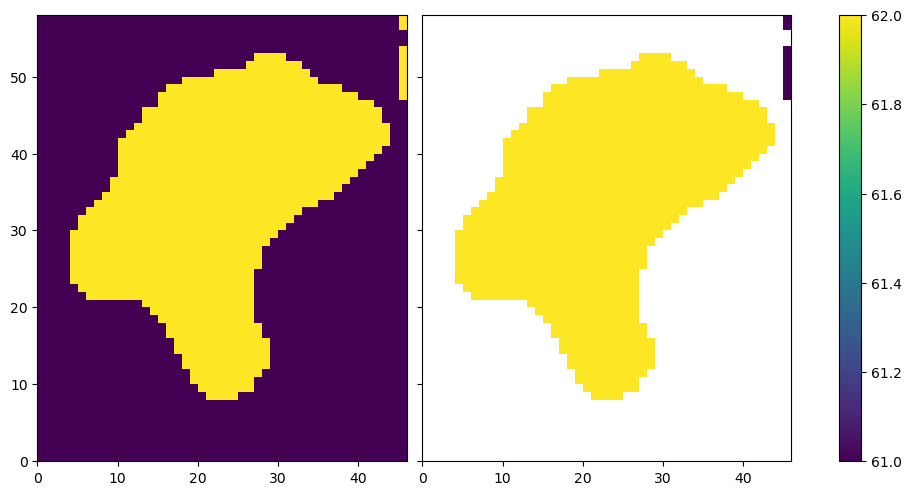

In [71]:
lat = [-71.68, -70.9]
lon = [-11.8, -9.9]
plot()

1142 1472 8140 8387


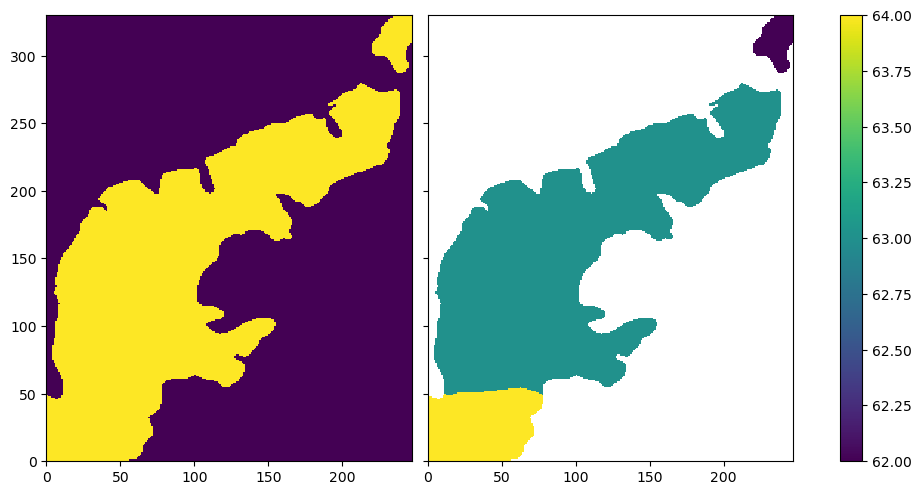

In [75]:
lat = [-75, -71]
lon = [-20.8, -10.5]

plot()

1036 1254 7967 8219


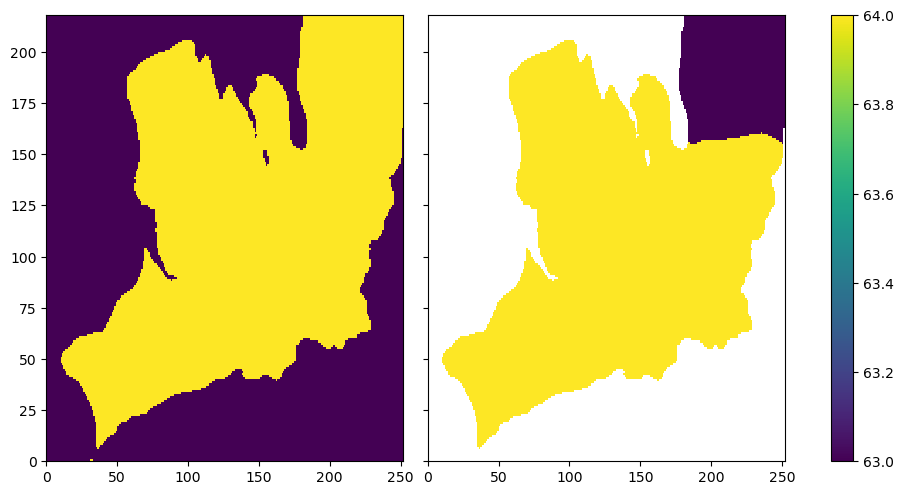

In [76]:
lat = [-76.1, -73.75]
lon = [-28, -17.5]

plot()

133 856 7151 7943


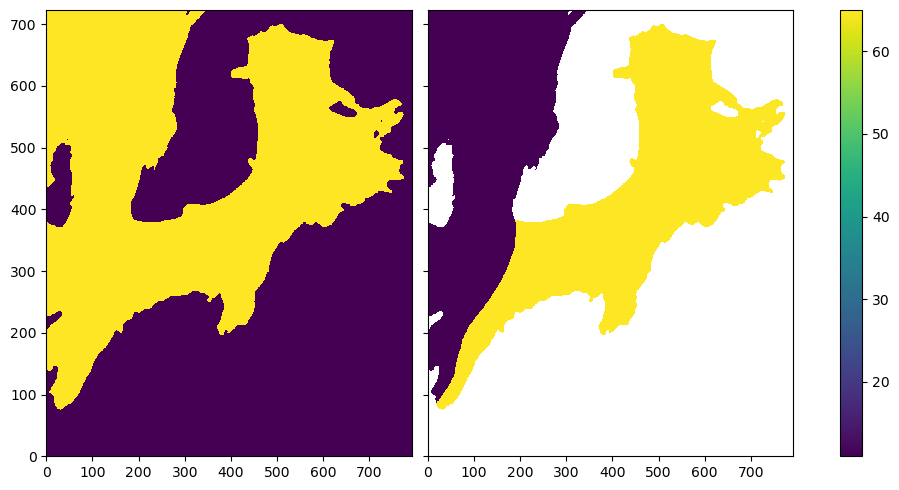

In [77]:
lat = [-84.3, -77.8]
lon = [-62,-29]

plot()